# Energy Saving Blueprint - PoC Demo

This notebook demonstrates intent-driven energy optimization in 5G networks.

**Workflow:**
1. Load 24-hour KPI data from CSV (UE and Cell reports)
2. Accept operator intent (QoS threshold)
3. Generate decisions for each 15-minute interval (96 total)
4. Output filtered decision table (Sleep/Wake actions only)
5. Execute decisions on RSG simulator at correct timestamps

## 1. Setup

In [1]:
# Install dependencies
!pip install -q pandas sqlalchemy python-dotenv langchain-nvidia-ai-endpoints llama-index-llms-nvidia llama-index-embeddings-nvidia

In [2]:
import pandas as pd
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine, text
from langchain_nvidia_ai_endpoints import ChatNVIDIA
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# Load environment variables
load_dotenv()
NVIDIA_API_KEY = os.getenv('NVIDIA_API_KEY')

/Users/bimo.fransiscus/Code/es_blueprint/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [3]:
# Configuration
import os
from pathlib import Path

PROJECT_ROOT = Path(os.getcwd()).parent if Path(os.getcwd()).name == "notebooks" else Path(os.getcwd())
DATA_PATH = str(PROJECT_ROOT / "data")
CELL_REPORTS = f"{DATA_PATH}/CellReports.csv"
UE_REPORTS = f"{DATA_PATH}/UEReports.csv"

TABLE_NAME = "kpi_data"
LLM_MODEL = os.getenv("LLM_MODEL", "meta/llama-3.1-70b-instruct")
RSG_ADDRESS = os.getenv("RSG_ADDRESS", "")

## 2. Data Ingestion

In [4]:
# Load UE and Cell reports
df_ue = pd.read_csv(UE_REPORTS)
df_cell = pd.read_csv(CELL_REPORTS)

print(f"UEReports: {len(df_ue)} rows, {df_ue['Viavi.UE.Name'].nunique()} unique UEs")
print(f"CellReports: {len(df_cell)} rows, {df_cell['Viavi.Cell.Name'].nunique()} unique cells")

# Filter active UEs (throughput > 0.1 Mbps)
ACTIVE_THROUGHPUT_THRESHOLD = 0.1
active_ues = df_ue[df_ue['DRB.UEThpDl'] > ACTIVE_THROUGHPUT_THRESHOLD].copy()
print(f"\nActive UEs (throughput > {ACTIVE_THROUGHPUT_THRESHOLD} Mbps): {active_ues['Viavi.UE.Name'].nunique()} unique")

# Get cell-level PRB from CellReports
cell_prb = df_cell[['time (ms)', 'Viavi.Cell.Name', 'RRU.PrbTotDl', 'Viavi.isEnergySaving']].copy()
cell_prb = cell_prb.rename(columns={'RRU.PrbTotDl': 'Cell_PRB'})

# Get UE-level throughput from active UEs
ue_thp = active_ues[['time (ms)', 'Viavi.Cell.Name', 'Viavi.UE.Name', 'DRB.UEThpDl']].copy()
ue_thp = ue_thp.rename(columns={'DRB.UEThpDl': 'UE_Throughput'})

# Merge UE data with Cell data (join on time and cell)
merged_df = ue_thp.merge(cell_prb, on=['time (ms)', 'Viavi.Cell.Name'], how='left')

# Parse site and cell type from cell name (e.g., "S1/N12/C1" -> site="S1/C1", cell_type="N12")
merged_df['site'] = merged_df['Viavi.Cell.Name'].str.split('/').str[0] + '/' + merged_df['Viavi.Cell.Name'].str.split('/').str[2]
merged_df['cell'] = merged_df['Viavi.Cell.Name'].str.split('/').str[1]

# Rename columns for SQL table
df = merged_df.rename(columns={
    'time (ms)': 'time',
    'Viavi.Cell.Name': 'cell_full',
    'Viavi.UE.Name': 'ue_name',
    'Viavi.isEnergySaving': 'is_sleeping'
})

print(f"\n✓ Merged data: {len(df)} active UE data points")
print(f"✓ Sites: {df['site'].nunique()}")
print(f"✓ Time points: {df['time'].nunique()}")
print(f"\nSample data:")
df[['time', 'site', 'cell', 'ue_name', 'Cell_PRB', 'UE_Throughput']].head(10)

UEReports: 13600 rows, 490 unique UEs
CellReports: 4032 rows, 42 unique cells

Active UEs (throughput > 0.1 Mbps): 490 unique

✓ Merged data: 13600 active UE data points
✓ Sites: 21
✓ Time points: 96

Sample data:


,time,site,cell,ue_name,Cell_PRB,UE_Throughput
0,1672531200000,S5/C3,N12,Indoor-1,20.01000,7.85539
1,1672531200000,S2/C2,N12,Indoor-2,19.98440,7.85539
2,1672531200000,S1/C1,N12,Indoor-3,9.96667,7.85482
3,1672531200000,S2/C1,N1,Indoor-4,9.96667,7.85392
4,1672531200000,S1/C3,N12,Indoor-5,19.97560,7.85478
5,1672531200000,S4/C3,N12,Pedestrian-6,10.01000,7.85539
6,1672531200000,S5/C3,N12,Pedestrian-7,20.01000,7.85461
7,1672531200000,S7/C2,N12,Pedestrian-8,10.01000,7.85539
8,1672531200000,S2/C1,N12,Pedestrian-9,20.05670,7.85539
9,1672531200000,S4/C2,N1,Pedestrian-10,10.01560,7.50746


In [5]:
# Store in SQLite
engine = create_engine('sqlite:///:memory:')
df.to_sql(TABLE_NAME, engine, if_exists='replace', index=False)

print(f"✓ Data stored in database table: {TABLE_NAME}")

✓ Data stored in database table: kpi_data


## 3. Intent Input

In [6]:
import re

# Get QoS range from data
min_qos = df['UE_Throughput'].min()
max_qos = df['UE_Throughput'].max()

print("="*60)
print("OPERATOR INTENT")
print("="*60)
print(f"\nNetwork QoS range: [{min_qos:.1f}, {max_qos:.1f}] Mbps")

# Get intent from user
operator_intent = input("\nEnter intent (or press Enter for default): ").strip()

if not operator_intent:
    operator_intent = "Optimize energy while maintaining throughput above 1 Mbps"
    QOS_THRESHOLD = 1.0
    print("Using default intent")
else:
    # Extract QoS threshold from intent
    qos_match = re.search(r'(\d+)\s*Mbps', operator_intent, re.IGNORECASE)
    if qos_match:
        QOS_THRESHOLD = float(qos_match.group(1))
    else:
        QOS_THRESHOLD = 1.0
        print("No threshold found, using 1 Mbps")

print(f"\n✓ Intent: '{operator_intent}'")
print(f"✓ QoS Threshold: {QOS_THRESHOLD} Mbps")
print("="*60)

OPERATOR INTENT

Network QoS range: [0.1, 7.9] Mbps



Enter intent (or press Enter for default):  Optimize energy while maintaining throughput above 10 Mbps



✓ Intent: 'Optimize energy while maintaining throughput above 10 Mbps'
✓ QoS Threshold: 10.0 Mbps


In [7]:
# =============================================================================
# Virtual Time Zone (VTZ) — Map timestamps to traffic profiles
# =============================================================================
# Each 15-min interval in the dataset has a real UTC timestamp (e.g. 2023-01-01 01:00 UTC).
# VTZ maps any timestamp to the corresponding traffic profile so we know which
# RSG simulation configuration (UE count) to use.
#
# Traffic variation model:
#   - Throughput per UE is STATIC (constant across all periods)
#   - Number of active UEs varies per period via a multiplier (ue_ratio)
#   - ue_count = DEFAULT_UE_COUNT * ue_ratio
# =============================================================================
from datetime import datetime, timezone

# ---- Scenario defaults ----
DEFAULT_UE_COUNT = 200          # Base UE count from default scenario (active UEs in baseline)
DEFAULT_THROUGHPUT_MBPS = 8.0   # Static throughput per UE (constant for all periods)

# ---- Traffic Profiles (UE ratio model) ----
traffic_profiles = [
    {"name": "Night",       "start_hour": 0,  "duration_hours": 8,  "ue_ratio": 0.1, "description": "Low traffic"},
    {"name": "Morning",     "start_hour": 8,  "duration_hours": 1,  "ue_ratio": 1.5, "description": "Medium traffic"},
    {"name": "Mid-day",     "start_hour": 9,  "duration_hours": 4,  "ue_ratio": 1, "description": "Normal traffic"},
    {"name": "Afternoon",   "start_hour": 13, "duration_hours": 5,  "ue_ratio": 0.5, "description": "Normal traffic"},
    {"name": "Evening",     "start_hour": 18, "duration_hours": 4,  "ue_ratio": 2, "description": "Peak traffic"},
    {"name": "Late Night",  "start_hour": 22, "duration_hours": 2,  "ue_ratio": 0.1, "description": "Low traffic"},
]

# Compute ue_count for each profile
for p in traffic_profiles:
    p["ue_count"] = int(DEFAULT_UE_COUNT * p["ue_ratio"])

# ---- Dict lookup by profile name: traffic_profiles_by_name["Night"] ----
traffic_profiles_by_name = {p["name"]: p for p in traffic_profiles}

# ---- VTZ mapping function ----
def vtz_get_profile(dt):
    """Map a datetime object to its traffic profile."""
    hour = dt.hour
    for p in traffic_profiles:
        if p["start_hour"] <= hour < p["start_hour"] + p["duration_hours"]:
            return {**p, "resolved_hour": hour, "resolved_datetime": dt}
    return None

# ---- Demo ----
print("="*70)
print("VIRTUAL TIME ZONE (VTZ) — Traffic Profile Mapping")
print("="*70)
print(f"\nScenario defaults:")
print(f"  Base UE count:          {DEFAULT_UE_COUNT}")
print(f"  Static throughput/UE:   {DEFAULT_THROUGHPUT_MBPS} Mbps")

print(f"\n{'Profile':<12} {'Hours':<14} {'UE Ratio':<10} {'UE Count':<10} {'Description'}")
print("-"*60)
for p in traffic_profiles:
    end = p['start_hour'] + p['duration_hours']
    print(f"{p['name']:<12} {p['start_hour']:02d}:00-{end:02d}:00   {p['ue_ratio']:<10.2f} {p['ue_count']:<10} {p['description']}")

# Example mappings
print(f"\nExample VTZ lookups:")
examples = [
    datetime(2023, 1, 1, 1, 0, tzinfo=timezone.utc),
    datetime(2023, 1, 1, 8, 30, tzinfo=timezone.utc),
    datetime(2023, 1, 1, 14, 0, tzinfo=timezone.utc),
    datetime(2023, 1, 1, 19, 0, tzinfo=timezone.utc),
]
for dt in examples:
    profile = vtz_get_profile(dt)
    print(f"  {dt.strftime('%Y-%m-%d %H:%M UTC')}  →  {profile['name']} (ratio={profile['ue_ratio']}, UEs={profile['ue_count']})")

print("="*70)

VIRTUAL TIME ZONE (VTZ) — Traffic Profile Mapping

Scenario defaults:
  Base UE count:          200
  Static throughput/UE:   8.0 Mbps

Profile      Hours          UE Ratio   UE Count   Description
------------------------------------------------------------
Night        00:00-08:00   0.10       20         Low traffic
Morning      08:00-09:00   1.50       300        Medium traffic
Mid-day      09:00-13:00   1.00       200        Normal traffic
Afternoon    13:00-18:00   0.50       100        Normal traffic
Evening      18:00-22:00   2.00       400        Peak traffic
Late Night   22:00-24:00   0.10       20         Low traffic

Example VTZ lookups:
  2023-01-01 01:00 UTC  →  Night (ratio=0.1, UEs=20)
  2023-01-01 08:30 UTC  →  Morning (ratio=1.5, UEs=300)
  2023-01-01 14:00 UTC  →  Afternoon (ratio=0.5, UEs=100)
  2023-01-01 19:00 UTC  →  Evening (ratio=2, UEs=400)


## 4. Closed-Loop Engine

In [8]:
# Initialize NVIDIA LLM
llm = ChatNVIDIA(
    model=LLM_MODEL,
    api_key=NVIDIA_API_KEY,
    temperature=0.2,
    max_completion_tokens=1024
)

In [ ]:
# =============================================================================
# Closed-Loop Helper Functions
# =============================================================================
from dataclasses import dataclass, field
from datetime import datetime, timedelta, timezone
from typing import Dict, List, Optional
import time as time_module

@dataclass
class LoopState:
    """Carries state across closed-loop iterations."""
    cell_sleep_state: Dict[str, bool] = field(default_factory=dict)   # cell_name -> True if sleeping
    prev_kpis: Optional[Dict] = None                                   # KPIs from Sim #2 of previous iteration
    iteration_log: List[Dict] = field(default_factory=list)            # accumulated log


def datetime_to_baseline_timestamp(Tv, all_timestamps):
    """Map a Tv datetime to the nearest baseline dataset timestamp (ms)."""
    index = Tv.hour * 4 + Tv.minute // 15
    index = min(index, len(all_timestamps) - 1)
    return all_timestamps[index]


def get_baseline_kpis_for_interval(engine, timestamp_ms, df_ue, df_cell):
    """Extract per-site KPIs from baseline dataset for a specific 15-min interval."""
    # Filter baseline data to this timestamp
    ue_slice = df_ue[df_ue['time (ms)'] == timestamp_ms]
    cell_slice = df_cell[df_cell['time (ms)'] == timestamp_ms]

    if len(ue_slice) == 0 and len(cell_slice) == 0:
        return None

    # Overall metrics
    avg_thp = ue_slice['DRB.UEThpDl'].mean() if len(ue_slice) > 0 else 0.0
    avg_power = cell_slice['PEE.AvgPower'].mean() if len(cell_slice) > 0 else 0.0

    # Per-site breakdown
    per_site = {}
    if len(cell_slice) > 0:
        for _, row in cell_slice.iterrows():
            cell_name = row['Viavi.Cell.Name']
            parts = cell_name.split('/')
            site = f"{parts[0]}/{parts[2]}"
            cell_type = parts[1]  # N1 or N12

            if site not in per_site:
                per_site[site] = {'n1_prb': 0.0, 'n12_prb': 0.0, 'avg_qos': 0.0, 'n1_sleeping': False}

            if cell_type == 'N1':
                per_site[site]['n1_prb'] = row.get('RRU.PrbTotDl', 0.0)
                per_site[site]['n1_sleeping'] = bool(row.get('Viavi.isEnergySaving', 0))
            elif cell_type == 'N12':
                per_site[site]['n12_prb'] = row.get('RRU.PrbTotDl', 0.0)

    # Add avg QoS per site from UE data
    if len(ue_slice) > 0:
        for _, row in ue_slice.iterrows():
            cell_name = row['Viavi.Cell.Name']
            parts = cell_name.split('/')
            site = f"{parts[0]}/{parts[2]}"
            if site in per_site:
                # accumulate - will average later
                if 'qos_values' not in per_site[site]:
                    per_site[site]['qos_values'] = []
                per_site[site]['qos_values'].append(row['DRB.UEThpDl'])

    # Average QoS
    for site in per_site:
        if 'qos_values' in per_site[site]:
            per_site[site]['avg_qos'] = sum(per_site[site]['qos_values']) / len(per_site[site]['qos_values'])
            del per_site[site]['qos_values']

    sleeping_count = sum(1 for s in per_site.values() if s.get('n1_sleeping', False))
    total_count = len(per_site)

    return {
        'avg_throughput_mbps': avg_thp,
        'avg_power_w': avg_power,
        'sleeping_cells': sleeping_count,
        'total_cells': total_count,
        'per_site': per_site,
    }


def compute_kpis(sim_ue, sim_cell):
    """Transform raw RSG query results into structured KPI dict."""
    avg_thp = sim_ue['DRB.UEThpDl'].mean() if len(sim_ue) > 0 else 0.0
    avg_power = sim_cell['PEE.AvgPower'].mean() if len(sim_cell) > 0 else 0.0

    per_site = {}
    if len(sim_cell) > 0:
        for _, row in sim_cell.iterrows():
            cell_name = row['Viavi.Cell.Name']
            parts = cell_name.split('/')
            site = f"{parts[0]}/{parts[2]}"
            cell_type = parts[1]

            if site not in per_site:
                per_site[site] = {'n1_prb': 0.0, 'n12_prb': 0.0, 'avg_qos': 0.0, 'n1_sleeping': False}

            if cell_type == 'N1':
                per_site[site]['n1_prb'] = row.get('RRU.PrbTotDl', 0.0)
                per_site[site]['n1_sleeping'] = bool(row.get('Viavi.isEnergySaving', 0))
            elif cell_type == 'N12':
                per_site[site]['n12_prb'] = row.get('RRU.PrbTotDl', 0.0)

    # UE throughput per site
    if len(sim_ue) > 0:
        for _, row in sim_ue.iterrows():
            cell_name = row['Viavi.Cell.Name']
            parts = cell_name.split('/')
            site = f"{parts[0]}/{parts[2]}"
            if site in per_site:
                if 'qos_values' not in per_site[site]:
                    per_site[site]['qos_values'] = []
                per_site[site]['qos_values'].append(row['DRB.UEThpDl'])

    for site in per_site:
        if 'qos_values' in per_site[site]:
            per_site[site]['avg_qos'] = sum(per_site[site]['qos_values']) / len(per_site[site]['qos_values'])
            del per_site[site]['qos_values']

    sleeping_count = sum(1 for s in per_site.values() if s.get('n1_sleeping', False))

    return {
        'avg_throughput_mbps': avg_thp,
        'avg_power_w': avg_power,
        'sleeping_cells': sleeping_count,
        'total_cells': len(per_site),
        'per_site': per_site,
    }


def format_kpis_for_prompt(kpis):
    """Format KPI dict into a readable table string for LLM prompts."""
    if kpis is None:
        return "No previous KPI data available."

    lines = []
    lines.append(f"Overall: avg_throughput={kpis['avg_throughput_mbps']:.2f} Mbps, "
                 f"avg_power={kpis['avg_power_w']:.1f} W, "
                 f"sleeping_cells={kpis['sleeping_cells']}/{kpis['total_cells']}")

    if kpis.get('per_site'):
        lines.append(f"{'Site':<8} | {'N1 PRB':>7} | {'N12 PRB':>8} | {'Avg QoS':>9} | {'N1 State':>10}")
        lines.append("-" * 55)
        for site in sorted(kpis['per_site'].keys()):
            s = kpis['per_site'][site]
            state = "Sleeping" if s.get('n1_sleeping', False) else "Awake"
            lines.append(f"{site:<8} | {s['n1_prb']:>6.1f}% | {s['n12_prb']:>7.1f}% | "
                         f"{s['avg_qos']:>7.2f}   | {state:>10}")

    return "\n".join(lines)


def llm_generate_recommendations(llm, Tv, profile, loop_state, operator_intent,
                                  qos_threshold, all_sites, engine, df_ue, df_cell,
                                  all_timestamps):
    """LLM #1: Generate Sleep/Wake recommendations for current Tv interval."""
    import pandas as pd

    # Get baseline KPIs for this interval
    ts_ms = datetime_to_baseline_timestamp(Tv, all_timestamps)
    baseline_kpis = get_baseline_kpis_for_interval(engine, ts_ms, df_ue, df_cell)
    baseline_text = format_kpis_for_prompt(baseline_kpis) if baseline_kpis else "No baseline data for this interval."

    # Format previous iteration results
    prev_text = format_kpis_for_prompt(loop_state.prev_kpis) if loop_state.prev_kpis else "No previous iteration data (first iteration)."

    # Current cell sleep states
    sleep_states_text = ""
    if loop_state.cell_sleep_state:
        sleeping = [c for c, v in loop_state.cell_sleep_state.items() if v]
        awake = [c for c, v in loop_state.cell_sleep_state.items() if not v]
        sleep_states_text = f"Currently sleeping: {sleeping if sleeping else 'None'}\nCurrently awake: {awake if awake else 'All cells awake'}"
    else:
        sleep_states_text = "All cells awake (initial state)."

    prompt_text = f"""**Operator Intent:** "{operator_intent}" (QoS threshold: {qos_threshold} Mbps)

**Current Time:** {Tv.strftime('%Y-%m-%d %H:%M UTC')}
**Traffic Profile:** {profile['name']} (UE ratio: {profile['ue_ratio']}, description: {profile['description']})

**Current Cell States:**
{sleep_states_text}

**Baseline Dataset KPIs for this interval:**
{baseline_text}

**Previous Iteration RSG Simulation Results:**
{prev_text}

**All Sites:** {all_sites}

**Task:** Generate energy saving recommendations (Sleep or Wake N1 capacity cells) for the current 15-minute interval.

**Decision Rules:**
- SLEEP N1 if ALL conditions met:
  - N12 PRB < 35% 
  - N1 PRB < 12% 
  - AVG QoS >= threshold 
  - N1 is currently awake
- WAKE N1 if:
  - N12 PRB > 60% 
  - AND N1 is currently sleeping
- If no action is needed for a site, do NOT include it.

**IMPORTANT:** Only recommend actions that CHANGE the current state. Do not recommend Sleep for already-sleeping cells or Wake for already-awake cells.

Reply ONLY in this format (one line per recommendation, no header):
SITE | TARGET_CELL | ACTION | REASON

Where:
- SITE is like S1/C1
- TARGET_CELL is like S1/N1/C1
- ACTION is Sleep or Wake
- REASON is a brief explanation

If no actions are needed, reply with: NO_ACTIONS"""

    prompt_template = ChatPromptTemplate.from_messages([
        ("system", "You are a 5G network energy optimization expert. Generate concise Sleep/Wake recommendations based on network KPIs. Only recommend actions that change current state."),
        ("user", prompt_text)
    ])

    chain = prompt_template | llm | StrOutputParser()
    response = chain.invoke({})

    # Parse response into DataFrame
    rows = []
    for line in response.strip().split('\n'):
        line = line.strip()
        if 'NO_ACTIONS' in line.upper():
            break
        if '|' in line:
            parts = [p.strip() for p in line.split('|')]
            if len(parts) >= 4:
                site = parts[0]
                target_cell = parts[1]
                action = parts[2].strip().capitalize()
                reason = parts[3] if len(parts) > 3 else ''
                if action in ('Sleep', 'Wake'):
                    rows.append({
                        'site': site,
                        'target_cell': target_cell,
                        'action': action,
                        'reason': reason,
                    })

    return pd.DataFrame(rows) if rows else pd.DataFrame(columns=['site', 'target_cell', 'action', 'reason'])


def llm_validate_recommendations(llm, recommendations_df, sim1_kpis, Tv, profile,
                                  loop_state, operator_intent, qos_threshold):
    """LLM #2: Validate Sleep recommendations using Sim #1 KPIs (QoS check only).
    Returns approved-only DataFrame."""
    import pandas as pd

    if len(recommendations_df) == 0:
        return pd.DataFrame(columns=['site', 'target_cell', 'action', 'reason'])

    # Format recommendations + sim1 KPIs
    recs_text = ""
    for idx, row in recommendations_df.iterrows():
        site = row['site']
        site_kpis = sim1_kpis.get('per_site', {}).get(site, {})
        recs_text += (f"{idx+1} | {row['action']} | {row['target_cell']} | "
                      f"QoS:{site_kpis.get('avg_qos', 0):.2f}Mbps | {row['reason']}\n")

    sim_summary = format_kpis_for_prompt(sim1_kpis)

    prompt_text = f"""**Operator Intent:** "{operator_intent}" (QoS threshold: {qos_threshold} Mbps)
**Current Time:** {Tv.strftime('%Y-%m-%d %H:%M UTC')}
**Traffic Profile:** {profile['name']}

**RSG Simulation #1 Results (testing Sleep recommendations):**
{sim_summary}

**Recommendations to Validate (# | ACTION | CELL | QoS | REASON):**
{recs_text}

**Task:** For each Sleep recommendation, decide YES (approve) or NO (reject) based on the simulation QoS results.

**Validation Criteria:**
- YES if: QoS >= {qos_threshold} Mbps after the Sleep action (service quality maintained)
- NO if: QoS < {qos_threshold} Mbps after the Sleep action (service quality degraded)

Reply ONLY in format: NUM | YES/NO | reason"""

    prompt_template = ChatPromptTemplate.from_messages([
        ("system", "You are a 5G network validation expert. Approve or reject Sleep recommendations based on QoS impact from RSG simulation results. Reply in format: NUM | YES/NO | reason"),
        ("user", prompt_text)
    ])

    chain = prompt_template | llm | StrOutputParser()
    response = chain.invoke({})

    # Parse response
    approved_indices = set()
    for line in response.strip().split('\n'):
        line = line.strip()
        if '|' in line:
            parts = [p.strip() for p in line.split('|')]
            if len(parts) >= 2:
                try:
                    num = int(parts[0].replace('.', '').strip())
                    decision = parts[1].strip().upper()
                    if 'YES' in decision:
                        approved_indices.add(num - 1)  # convert to 0-based
                except (ValueError, IndexError):
                    pass

    # Filter to approved only
    if approved_indices:
        approved_df = recommendations_df.iloc[list(approved_indices)].copy()
    else:
        approved_df = pd.DataFrame(columns=['site', 'target_cell', 'action', 'reason'])

    return approved_df


def run_sim(scenario, profile, actions_to_apply, loop_state):
    """Shared RSG simulation function for both Sim #1 and Sim #2.

    Returns KPIs dict from compute_kpis().
    NOTE: Does NOT update loop_state.cell_sleep_state — caller decides.
    """
    # 1. Set throughput based on profile
    target_ue_count = int(DEFAULT_UE_COUNT * profile['ue_ratio'])
    for ue_group in scenario.config["UE_Configuration"]["UE_Groups"]:
        ue_group["numUEs"] = target_ue_count
        if "serviceConfig" in ue_group:
            for service in ue_group["serviceConfig"]:
                service["targetTput_Mbps"] = DEFAULT_THROUGHPUT_MBPS

    # 2. Configure batch mode
    scenario.config['System']['batch_mode'] = True
    scenario.config['System']['duration'] = 10

    # 3. Start fresh simulation
    sim = scenario.simulation(force_start=True, adk_pace=True)
    sim.start()

    # 4. Re-apply accumulated sleep states
    for cell_name, is_sleeping in loop_state.cell_sleep_state.items():
        if is_sleeping:
            sim.command('turn_off', cell=cell_name, reason='Accumulated sleep state')
        else:
            sim.command('turn_on', cell=cell_name, reason='Accumulated awake state')

    # 5. Apply new actions
    if actions_to_apply is not None and len(actions_to_apply) > 0:
        for _, row in actions_to_apply.iterrows():
            target_cell = row['target_cell']
            action = row['action']
            if action == 'Sleep':
                sim.command('turn_off', cell=target_cell, reason=row.get('reason', 'Energy optimization'))
            elif action == 'Wake':
                sim.command('turn_on', cell=target_cell, reason=row.get('reason', 'Capacity needed'))

    # 6. Run simulation
    sim.run_for("10s")

    # 7. Query KPIs
    sim_ue = sim.query("UEReports", start=0, stop=10)
    sim_cell = sim.query("CellReports", start=0, stop=10)

    # 8. Stop simulation
    sim.finish()

    # 9. Compute and return KPIs
    return compute_kpis(sim_ue, sim_cell)

In [10]:
# =============================================================================
# Main Closed-Loop Function
# =============================================================================

def run_closed_loop(llm, scenario, engine, df_ue, df_cell, all_timestamps,
                    all_sites, operator_intent, qos_threshold,
                    start_datetime, num_iterations):
    """
    Run the closed-loop per-interval iteration engine.

    7-step loop per iteration:
      1. LLM #1: Generate Sleep/Wake recommendations
      2. Blueprint picks (implicit — LLM is profile-aware)
      3. RSG Sim #1: Test Sleep recommendations with current profile
         (Wake recs bypass — wake is non-destructive per Flow.md)
      4. LLM #2: Validate Sleep recs using Sim #1 KPIs → approved list
         Wake recs auto-approved and concatenated
      5. Advance Tv by 15 min
      6. RSG Sim #2: Apply approved actions with next profile
      7. Feed Sim #2 KPIs back to next iteration

    Returns:
        (loop_state, summary_df) — LoopState and DataFrame of iteration summaries
    """
    import pandas as pd

    loop_state = LoopState()
    Tv = start_datetime

    print("=" * 80)
    print("CLOSED-LOOP PER-INTERVAL ENGINE")
    print("=" * 80)
    print(f"Start time: {Tv.strftime('%Y-%m-%d %H:%M UTC')}")
    print(f"Iterations: {num_iterations}")
    print(f"Operator intent: {operator_intent}")
    print(f"QoS threshold: {qos_threshold} Mbps")
    print("=" * 80)

    engine_start = time_module.time()

    for iteration in range(num_iterations):
        iter_start = time_module.time()
        profile = vtz_get_profile(Tv)
        if profile is None:
            print(f"\n⚠ Iteration {iteration+1}: No profile for {Tv}, skipping")
            Tv = Tv + timedelta(minutes=15)
            continue

        print(f"\n{'─' * 80}")
        print(f"ITERATION {iteration+1}/{num_iterations} | {Tv.strftime('%H:%M UTC')} | Profile: {profile['name']} (ratio={profile['ue_ratio']})")
        print(f"{'─' * 80}")

        sleeping_count = sum(1 for v in loop_state.cell_sleep_state.values() if v)
        print(f"  Current state: {sleeping_count} cells sleeping")

        # Seed prev_kpis from baseline on first iteration
        if loop_state.prev_kpis is None:
            ts_ms = datetime_to_baseline_timestamp(Tv, all_timestamps)
            loop_state.prev_kpis = get_baseline_kpis_for_interval(engine, ts_ms, df_ue, df_cell)
            print(f"  Seeded prev_kpis from baseline (ts={ts_ms})")

        # ── Step 1: LLM #1 — Generate recommendations ──
        print(f"  Step 1: LLM generating recommendations...")
        t0 = time_module.time()
        recommendations = llm_generate_recommendations(
            llm, Tv, profile, loop_state, operator_intent,
            qos_threshold, all_sites, engine, df_ue, df_cell, all_timestamps
        )
        t_llm1 = time_module.time() - t0

        # Split: Wake bypasses Sim #1 + LLM #2 (wake is non-destructive)
        sleep_recs = recommendations[recommendations['action'] == 'Sleep'].reset_index(drop=True)
        wake_recs = recommendations[recommendations['action'] == 'Wake'].reset_index(drop=True)
        n_sleep, n_wake = len(sleep_recs), len(wake_recs)

        parts = []
        if n_sleep > 0:
            parts.append(f"{n_sleep} Sleep")
        if n_wake > 0:
            parts.append(f"{n_wake} Wake (auto-approved)")
        count_str = ", ".join(parts) if parts else "0"
        print(f"    → {len(recommendations)} recommendations generated: {count_str} ({t_llm1:.1f}s)")
        if len(recommendations) > 0:
            for _, r in recommendations.iterrows():
                tag = " [auto-approved]" if r['action'] == 'Wake' else ""
                print(f"      {r['action']:5s} {r['target_cell']} — {r.get('reason', '')[:60]}{tag}")

        # ── Step 2: Blueprint picks (implicit in LLM prompt) ──

        # ── Step 3: RSG Sim #1 — Test Sleep recommendations only ──
        t_sim1 = 0.0
        if n_sleep > 0:
            print(f"  Step 3: RSG Sim #1 (testing {n_sleep} Sleep recommendations)...")
            t0 = time_module.time()
            sim1_kpis = run_sim(scenario, profile, sleep_recs, loop_state)
            t_sim1 = time_module.time() - t0
            print(f"    → avg_thp={sim1_kpis['avg_throughput_mbps']:.2f} Mbps, "
                  f"power={sim1_kpis['avg_power_w']:.1f} W, "
                  f"sleeping={sim1_kpis['sleeping_cells']}/{sim1_kpis['total_cells']} ({t_sim1:.1f}s)")
        else:
            sim1_kpis = loop_state.prev_kpis or {}
            print(f"  Step 3: Skipped (no Sleep recommendations)")

        t_llm2 = 0.0
        # ── Step 4: LLM #2 — Validate Sleep recommendations only ──
        if n_sleep > 0:
            print(f"  Step 4: LLM validating {n_sleep} Sleep recommendations...")
            t0 = time_module.time()
            approved_sleep = llm_validate_recommendations(
                llm, sleep_recs, sim1_kpis, Tv, profile,
                loop_state, operator_intent, qos_threshold
            )
            t_llm2 = time_module.time() - t0
        else:
            approved_sleep = pd.DataFrame(columns=['site', 'target_cell', 'action', 'reason'])

        # Wake always approved — concat with validated Sleep
        approved = pd.concat([approved_sleep, wake_recs], ignore_index=True)

        # Print Step 4 summary
        if n_sleep > 0 or n_wake > 0:
            parts = []
            if n_sleep > 0:
                parts.append(f"{len(approved_sleep)}/{n_sleep} Sleep approved")
            if n_wake > 0:
                parts.append(f"{n_wake} Wake (auto-approved)")
            summary = " + ".join(parts) + f" = {len(approved)} total"
            print(f"    → {summary} ({t_llm2:.1f}s)")
            if len(approved) > 0:
                for _, a in approved.iterrows():
                    tag = " [auto]" if a['action'] == 'Wake' else ""
                    print(f"      ✓ {a['action']:5s} {a['target_cell']}{tag}")
        else:
            print(f"  Step 4: Skipped (no recommendations)")

        # ── Step 5: Advance Tv ──
        Tv = Tv + timedelta(minutes=15)
        next_profile = vtz_get_profile(Tv)
        if next_profile is None:
            # Wrap around to start of day
            Tv = Tv.replace(hour=0, minute=0)
            next_profile = vtz_get_profile(Tv)
        print(f"  Step 5: Tv → {Tv.strftime('%H:%M UTC')} (profile: {next_profile['name']})")

        # ── Step 6: RSG Sim #2 — Apply approved actions ──
        # Update cell_sleep_state ONLY from approved actions
        if len(approved) > 0:
            for _, row in approved.iterrows():
                cell_name = row['target_cell']
                if row['action'] == 'Sleep':
                    loop_state.cell_sleep_state[cell_name] = True
                elif row['action'] == 'Wake':
                    loop_state.cell_sleep_state[cell_name] = False

        print(f"  Step 6: RSG Sim #2 (approved actions + next profile)...")
        t0 = time_module.time()
        sim2_kpis = run_sim(scenario, next_profile, None, loop_state)
        t_sim2 = time_module.time() - t0
        # NOTE: actions already in cell_sleep_state, no new actions passed
        print(f"    → avg_thp={sim2_kpis['avg_throughput_mbps']:.2f} Mbps, "
              f"power={sim2_kpis['avg_power_w']:.1f} W, "
              f"sleeping={sim2_kpis['sleeping_cells']}/{sim2_kpis['total_cells']} ({t_sim2:.1f}s)")

        # ── Step 7: Feed back ──
        loop_state.prev_kpis = sim2_kpis

        sleeping_after = sum(1 for v in loop_state.cell_sleep_state.values() if v)
        iter_elapsed = time_module.time() - iter_start
        loop_state.iteration_log.append({
            'iteration': iteration + 1,
            'time_utc': (Tv - timedelta(minutes=15)).strftime('%Y-%m-%d %H:%M'),
            'profile': profile['name'],
            'ue_ratio': profile['ue_ratio'],
            'recommendations_generated': len(recommendations),
            'recommendations_approved': len(approved),
            'sleeping_cells': sleeping_after,
            'total_cells': len(all_sites),
            'sim1_avg_thp': sim1_kpis.get('avg_throughput_mbps', 0),
            'sim1_avg_power': sim1_kpis.get('avg_power_w', 0),
            'sim2_avg_thp': sim2_kpis['avg_throughput_mbps'],
            'sim2_avg_power': sim2_kpis['avg_power_w'],
            'iter_time_s': iter_elapsed,
            'llm1_time_s': t_llm1,
            'sim1_time_s': t_sim1,
            'llm2_time_s': t_llm2,
            'sim2_time_s': t_sim2,
        })
        total_elapsed = time_module.time() - engine_start
        avg_per_iter = total_elapsed / (iteration + 1)
        remaining = avg_per_iter * (num_iterations - iteration - 1)
        print(f"  ✓ Iteration {iteration+1} complete — {sleeping_after} cells sleeping")
        print(f"    Timing: LLM1={t_llm1:.1f}s  Sim1={t_sim1:.1f}s  LLM2={t_llm2:.1f}s  Sim2={t_sim2:.1f}s  |  Iter={iter_elapsed:.1f}s")
        print(f"    Elapsed: {total_elapsed:.0f}s ({total_elapsed/60:.1f}min)  |  ETA: {remaining:.0f}s ({remaining/60:.1f}min)")

    total_time = time_module.time() - engine_start
    print("\n" + "=" * 80)
    print("CLOSED-LOOP ENGINE COMPLETE")
    print("=" * 80)
    print(f"Total iterations: {num_iterations}")
    print(f"Final sleeping cells: {sum(1 for v in loop_state.cell_sleep_state.values() if v)}")
    print(f"Total wall time: {total_time:.1f}s ({total_time/60:.1f}min)")
    print(f"Avg per iteration: {total_time/max(num_iterations,1):.1f}s")
    print("=" * 80)

    summary_df = pd.DataFrame(loop_state.iteration_log)
    return loop_state, summary_df

## 5. Execute Closed-Loop Simulation

Run the closed-loop engine: each 15-minute interval goes through LLM recommendation → RSG simulation → LLM validation → RSG confirmation.

In [ ]:
# =============================================================================
# Execution — Closed-Loop Simulation
# =============================================================================
from viavi.rsg import Scenario

RSG_ADDRESS = os.getenv("RSG_ADDRESS", "http://10.66.30.11:8001")
scenario_name = "Scenario with 2 layers, static + indoor UE v3"

scenario = Scenario(scenario_name, RSG_ADDRESS)
print(f"✓ Scenario loaded: {scenario_name}")

# Pre-calculate avg QoS (needed by helper functions)
avg_qos = df.groupby(['time', 'site'])['UE_Throughput'].mean().reset_index()
avg_qos = avg_qos.rename(columns={'UE_Throughput': 'avg_qos'})

from sqlalchemy import text
with engine.connect() as conn:
    conn.execute(text("DROP TABLE IF EXISTS site_avg_qos"))
    conn.commit()
avg_qos.to_sql('site_avg_qos', engine, index=False, if_exists='replace')
print(f"✓ Pre-calculated avg QoS for {len(avg_qos)} (time, site) combinations")

# All timestamps and sites from dataset
all_timestamps = sorted(df['time'].unique())
all_sites = sorted(df['site'].unique())

# ms_to_datetime utility
def ms_to_datetime(ms):
    """Convert milliseconds timestamp to UTC datetime string."""
    return datetime.fromtimestamp(ms / 1000, tz=timezone.utc).strftime('%Y-%m-%d %H:%M UTC')

print(f"✓ {len(all_timestamps)} timestamps, {len(all_sites)} sites")

# ── User Configuration ──
START_DATETIME = datetime(2023, 1, 1, 0, 0, tzinfo=timezone.utc)
NUM_ITERATIONS = 4  # Full 24h (set to 4 for quick test = 1 hour)

print(f"\nStarting closed-loop: {START_DATETIME.strftime('%Y-%m-%d %H:%M UTC')}, {NUM_ITERATIONS} iterations")

# ── Execute ──
loop_state, summary_df = run_closed_loop(
    llm=llm,
    scenario=scenario,
    engine=engine,
    df_ue=df_ue,
    df_cell=df_cell,
    all_timestamps=all_timestamps,
    all_sites=all_sites,
    operator_intent=operator_intent,
    qos_threshold=QOS_THRESHOLD,
    start_datetime=START_DATETIME,
    num_iterations=NUM_ITERATIONS,
)

# Display summary
print("\n" + "=" * 100)
print("ITERATION SUMMARY")
print("=" * 100)
print(summary_df.to_string(index=False))
print("=" * 100)

✓ Scenario loaded: Scenario with 2 layers, static + indoor UE v3
✓ Pre-calculated avg QoS for 1736 (time, site) combinations
✓ 96 timestamps, 21 sites

Starting closed-loop: 2023-01-01 00:00 UTC, 96 iterations
CLOSED-LOOP PER-INTERVAL ENGINE
Start time: 2023-01-01 00:00 UTC
Iterations: 96
Operator intent: Optimize energy while maintaining throughput above 10 Mbps
QoS threshold: 10.0 Mbps

────────────────────────────────────────────────────────────────────────────────
ITERATION 1/96 | 00:00 UTC | Profile: Night (ratio=0.1)
────────────────────────────────────────────────────────────────────────────────
  Current state: 0 cells sleeping
  Seeded prev_kpis from baseline (ts=1672531200000)
  Step 1: LLM generating recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 7 recommendations generated: 7 Sleep (3.9s)
      Sleep S2/N1/C3 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S3/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S3/N1/C2 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S5/N1/C2 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S6/N1/C2 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S6/N1/C3 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S7/N1/C3 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
  Step 3: RSG Sim #1 (testing 7 Sleep recommendations)...


INFO:root:Stopping sim rsg-359
INFO:root:Simulation rsg-359 reached status "STOPPED at 2026-02-11T09:20:13.605+00:00Z" after 2 seconds
INFO:root:Started simulation 'rsg-360'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-360 reached status "PAUSED ADK Scheduled Pause #1" after 2 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-360 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-360
INFO:root:Simulation rsg-360 reached status "STOPPED at 2026-02-11T09:20:43.176+00:00Z" after 2 seconds


    → avg_thp=1.17 Mbps, power=78.7 W, sleeping=7/21 (37.8s)
  Step 4: LLM validating 7 Sleep recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 5/7 Sleep approved = 5 total (2.9s)
      ✓ Sleep S2/N1/C3
      ✓ Sleep S3/N1/C1
      ✓ Sleep S5/N1/C2
      ✓ Sleep S6/N1/C2
      ✓ Sleep S6/N1/C3
  Step 5: Tv → 00:15 UTC (profile: Night)
  Step 6: RSG Sim #2 (approved actions + next profile)...


INFO:root:Started simulation 'rsg-361'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-361 reached status "PAUSED ADK Scheduled Pause #1" after 2 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-361 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-361
INFO:root:Simulation rsg-361 reached status "STOPPED at 2026-02-11T09:21:14.390+00:00Z" after 2 seconds


    → avg_thp=1.19 Mbps, power=78.5 W, sleeping=5/21 (28.6s)
  ✓ Iteration 1 complete — 5 cells sleeping
    Timing: LLM1=3.9s  Sim1=37.8s  LLM2=2.9s  Sim2=28.6s  |  Iter=73.1s
    Elapsed: 73s (1.2min)  |  ETA: 6947s (115.8min)

────────────────────────────────────────────────────────────────────────────────
ITERATION 2/96 | 00:15 UTC | Profile: Night (ratio=0.1)
────────────────────────────────────────────────────────────────────────────────
  Current state: 5 cells sleeping
  Step 1: LLM generating recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 5 recommendations generated: 5 Wake (auto-approved) (1.8s)
      Wake  S2/N1/C3 — N12 PRB > 60% [auto-approved]
      Wake  S3/N1/C1 — N12 PRB > 60% [auto-approved]
      Wake  S5/N1/C2 — N12 PRB > 60% [auto-approved]
      Wake  S6/N1/C2 — N12 PRB > 60% [auto-approved]
      Wake  S6/N1/C3 — N12 PRB > 60% [auto-approved]
  Step 3: Skipped (no Sleep recommendations)
    → 5 Wake (auto-approved) = 5 total (0.0s)
      ✓ Wake  S2/N1/C3 [auto]
      ✓ Wake  S3/N1/C1 [auto]
      ✓ Wake  S5/N1/C2 [auto]
      ✓ Wake  S6/N1/C2 [auto]
      ✓ Wake  S6/N1/C3 [auto]
  Step 5: Tv → 00:30 UTC (profile: Night)
  Step 6: RSG Sim #2 (approved actions + next profile)...


INFO:root:Started simulation 'rsg-362'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-362 reached status "PAUSED ADK Scheduled Pause #1" after 2 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-362 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-362
INFO:root:Simulation rsg-362 reached status "STOPPED at 2026-02-11T09:21:45.006+00:00Z" after 2 seconds


    → avg_thp=1.22 Mbps, power=80.9 W, sleeping=0/21 (28.6s)
  ✓ Iteration 2 complete — 0 cells sleeping
    Timing: LLM1=1.8s  Sim1=0.0s  LLM2=0.0s  Sim2=28.6s  |  Iter=30.4s
    Elapsed: 104s (1.7min)  |  ETA: 4867s (81.1min)

────────────────────────────────────────────────────────────────────────────────
ITERATION 3/96 | 00:30 UTC | Profile: Night (ratio=0.1)
────────────────────────────────────────────────────────────────────────────────
  Current state: 0 cells sleeping
  Step 1: LLM generating recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 0 recommendations generated: 0 (3.3s)
  Step 3: Skipped (no Sleep recommendations)
  Step 4: Skipped (no recommendations)
  Step 5: Tv → 00:45 UTC (profile: Night)
  Step 6: RSG Sim #2 (approved actions + next profile)...


INFO:root:Started simulation 'rsg-363'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-363 reached status "PAUSED ADK Scheduled Pause #1" after 2 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-363 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-363
INFO:root:Simulation rsg-363 reached status "STOPPED at 2026-02-11T09:22:16.860+00:00Z" after 2 seconds


    → avg_thp=1.22 Mbps, power=80.9 W, sleeping=0/21 (28.6s)
  ✓ Iteration 3 complete — 0 cells sleeping
    Timing: LLM1=3.3s  Sim1=0.0s  LLM2=0.0s  Sim2=28.6s  |  Iter=31.9s
    Elapsed: 135s (2.3min)  |  ETA: 4197s (70.0min)

────────────────────────────────────────────────────────────────────────────────
ITERATION 4/96 | 00:45 UTC | Profile: Night (ratio=0.1)
────────────────────────────────────────────────────────────────────────────────
  Current state: 0 cells sleeping
  Step 1: LLM generating recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 0 recommendations generated: 0 (3.4s)
  Step 3: Skipped (no Sleep recommendations)
  Step 4: Skipped (no recommendations)
  Step 5: Tv → 01:00 UTC (profile: Night)
  Step 6: RSG Sim #2 (approved actions + next profile)...


INFO:root:Started simulation 'rsg-364'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-364 reached status "PAUSED ADK Scheduled Pause #1" after 2 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-364 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-364
INFO:root:Simulation rsg-364 reached status "STOPPED at 2026-02-11T09:22:48.650+00:00Z" after 2 seconds


    → avg_thp=1.22 Mbps, power=80.8 W, sleeping=0/21 (28.5s)
  ✓ Iteration 4 complete — 0 cells sleeping
    Timing: LLM1=3.4s  Sim1=0.0s  LLM2=0.0s  Sim2=28.5s  |  Iter=31.9s
    Elapsed: 167s (2.8min)  |  ETA: 3847s (64.1min)

────────────────────────────────────────────────────────────────────────────────
ITERATION 5/96 | 01:00 UTC | Profile: Night (ratio=0.1)
────────────────────────────────────────────────────────────────────────────────
  Current state: 0 cells sleeping
  Step 1: LLM generating recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 6 recommendations generated: 6 Sleep (3.4s)
      Sleep S2/N1/C3 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold, N1 is cur
      Sleep S3/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold, N1 is cur
      Sleep S3/N1/C2 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold, N1 is cur
      Sleep S5/N1/C2 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold, N1 is cur
      Sleep S6/N1/C2 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold, N1 is cur
      Sleep S6/N1/C3 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold, N1 is cur
  Step 3: RSG Sim #1 (testing 6 Sleep recommendations)...


INFO:root:Started simulation 'rsg-365'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-365 reached status "PAUSED ADK Scheduled Pause #1" after 2 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-365 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-365
INFO:root:Simulation rsg-365 reached status "STOPPED at 2026-02-11T09:23:26.877+00:00Z" after 2 seconds


    → avg_thp=1.19 Mbps, power=78.0 W, sleeping=6/21 (34.8s)
  Step 4: LLM validating 6 Sleep recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 0/6 Sleep approved = 0 total (3.0s)
  Step 5: Tv → 01:15 UTC (profile: Night)
  Step 6: RSG Sim #2 (approved actions + next profile)...


INFO:root:Started simulation 'rsg-366'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-366 reached status "PAUSED ADK Scheduled Pause #1" after 2 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-366 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-366
INFO:root:Simulation rsg-366 reached status "STOPPED at 2026-02-11T09:23:58.428+00:00Z" after 2 seconds


    → avg_thp=1.22 Mbps, power=80.6 W, sleeping=0/21 (28.6s)
  ✓ Iteration 5 complete — 0 cells sleeping
    Timing: LLM1=3.4s  Sim1=34.8s  LLM2=3.0s  Sim2=28.6s  |  Iter=69.7s
    Elapsed: 237s (4.0min)  |  ETA: 4314s (71.9min)

────────────────────────────────────────────────────────────────────────────────
ITERATION 6/96 | 01:15 UTC | Profile: Night (ratio=0.1)
────────────────────────────────────────────────────────────────────────────────
  Current state: 0 cells sleeping
  Step 1: LLM generating recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 0 recommendations generated: 0 (2.5s)
  Step 3: Skipped (no Sleep recommendations)
  Step 4: Skipped (no recommendations)
  Step 5: Tv → 01:30 UTC (profile: Night)
  Step 6: RSG Sim #2 (approved actions + next profile)...


INFO:root:Started simulation 'rsg-367'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-367 reached status "PAUSED ADK Scheduled Pause #1" after 2 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-367 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-367
INFO:root:Simulation rsg-367 reached status "STOPPED at 2026-02-11T09:24:29.423+00:00Z" after 2 seconds


    → avg_thp=1.22 Mbps, power=80.5 W, sleeping=0/21 (28.5s)
  ✓ Iteration 6 complete — 0 cells sleeping
    Timing: LLM1=2.5s  Sim1=0.0s  LLM2=0.0s  Sim2=28.5s  |  Iter=31.1s
    Elapsed: 268s (4.5min)  |  ETA: 4022s (67.0min)

────────────────────────────────────────────────────────────────────────────────
ITERATION 7/96 | 01:30 UTC | Profile: Night (ratio=0.1)
────────────────────────────────────────────────────────────────────────────────
  Current state: 0 cells sleeping
  Step 1: LLM generating recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 0 recommendations generated: 0 (2.6s)
  Step 3: Skipped (no Sleep recommendations)
  Step 4: Skipped (no recommendations)
  Step 5: Tv → 01:45 UTC (profile: Night)
  Step 6: RSG Sim #2 (approved actions + next profile)...


INFO:root:Started simulation 'rsg-368'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-368 reached status "PAUSED ADK Scheduled Pause #1" after 2 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-368 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-368
INFO:root:Simulation rsg-368 reached status "STOPPED at 2026-02-11T09:25:00.826+00:00Z" after 2 seconds


    → avg_thp=1.22 Mbps, power=80.6 W, sleeping=0/21 (28.7s)
  ✓ Iteration 7 complete — 0 cells sleeping
    Timing: LLM1=2.6s  Sim1=0.0s  LLM2=0.0s  Sim2=28.7s  |  Iter=31.3s
    Elapsed: 299s (5.0min)  |  ETA: 3807s (63.4min)

────────────────────────────────────────────────────────────────────────────────
ITERATION 8/96 | 01:45 UTC | Profile: Night (ratio=0.1)
────────────────────────────────────────────────────────────────────────────────
  Current state: 0 cells sleeping
  Step 1: LLM generating recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 0 recommendations generated: 0 (2.9s)
  Step 3: Skipped (no Sleep recommendations)
  Step 4: Skipped (no recommendations)
  Step 5: Tv → 02:00 UTC (profile: Night)
  Step 6: RSG Sim #2 (approved actions + next profile)...


INFO:root:Started simulation 'rsg-369'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-369 reached status "PAUSED ADK Scheduled Pause #1" after 2 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-369 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-369
INFO:root:Simulation rsg-369 reached status "STOPPED at 2026-02-11T09:25:32.136+00:00Z" after 2 seconds


    → avg_thp=1.22 Mbps, power=80.2 W, sleeping=0/21 (28.8s)
  ✓ Iteration 8 complete — 0 cells sleeping
    Timing: LLM1=2.9s  Sim1=0.0s  LLM2=0.0s  Sim2=28.8s  |  Iter=31.7s
    Elapsed: 331s (5.5min)  |  ETA: 3642s (60.7min)

────────────────────────────────────────────────────────────────────────────────
ITERATION 9/96 | 02:00 UTC | Profile: Night (ratio=0.1)
────────────────────────────────────────────────────────────────────────────────
  Current state: 0 cells sleeping
  Step 1: LLM generating recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 7 recommendations generated: 7 Sleep (6.5s)
      Sleep S2/N1/C3 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold, N1 is cur
      Sleep S3/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold, N1 is cur
      Sleep S3/N1/C2 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold, N1 is cur
      Sleep S5/N1/C2 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold, N1 is cur
      Sleep S6/N1/C2 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold, N1 is cur
      Sleep S6/N1/C3 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold, N1 is cur
      Sleep S7/N1/C3 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold, N1 is cur
  Step 3: RSG Sim #1 (testing 7 Sleep recommendations)...


INFO:root:Started simulation 'rsg-370'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-370 reached status "PAUSED ADK Scheduled Pause #1" after 2 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-370 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-370
INFO:root:Simulation rsg-370 reached status "STOPPED at 2026-02-11T09:26:14.744+00:00Z" after 2 seconds


    → avg_thp=1.17 Mbps, power=78.7 W, sleeping=7/21 (35.6s)
  Step 4: LLM validating 7 Sleep recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 0/7 Sleep approved = 0 total (3.0s)
  Step 5: Tv → 02:15 UTC (profile: Night)
  Step 6: RSG Sim #2 (approved actions + next profile)...


INFO:root:Started simulation 'rsg-371'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-371 reached status "PAUSED ADK Scheduled Pause #1" after 2 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-371 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-371
INFO:root:Simulation rsg-371 reached status "STOPPED at 2026-02-11T09:26:46.193+00:00Z" after 2 seconds


    → avg_thp=1.22 Mbps, power=80.9 W, sleeping=0/21 (28.5s)
  ✓ Iteration 9 complete — 0 cells sleeping
    Timing: LLM1=6.5s  Sim1=35.6s  LLM2=3.0s  Sim2=28.5s  |  Iter=73.7s
    Elapsed: 405s (6.7min)  |  ETA: 3913s (65.2min)

────────────────────────────────────────────────────────────────────────────────
ITERATION 10/96 | 02:15 UTC | Profile: Night (ratio=0.1)
────────────────────────────────────────────────────────────────────────────────
  Current state: 0 cells sleeping
  Step 1: LLM generating recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 0 recommendations generated: 0 (3.4s)
  Step 3: Skipped (no Sleep recommendations)
  Step 4: Skipped (no recommendations)
  Step 5: Tv → 02:30 UTC (profile: Night)
  Step 6: RSG Sim #2 (approved actions + next profile)...


INFO:root:Started simulation 'rsg-372'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-372 reached status "PAUSED ADK Scheduled Pause #1" after 2 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-372 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-372
INFO:root:Simulation rsg-372 reached status "STOPPED at 2026-02-11T09:27:18.220+00:00Z" after 2 seconds


    → avg_thp=1.22 Mbps, power=80.8 W, sleeping=0/21 (28.5s)
  ✓ Iteration 10 complete — 0 cells sleeping
    Timing: LLM1=3.4s  Sim1=0.0s  LLM2=0.0s  Sim2=28.5s  |  Iter=31.9s
    Elapsed: 437s (7.3min)  |  ETA: 3755s (62.6min)

────────────────────────────────────────────────────────────────────────────────
ITERATION 11/96 | 02:30 UTC | Profile: Night (ratio=0.1)
────────────────────────────────────────────────────────────────────────────────
  Current state: 0 cells sleeping
  Step 1: LLM generating recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 0 recommendations generated: 0 (6.1s)
  Step 3: Skipped (no Sleep recommendations)
  Step 4: Skipped (no recommendations)
  Step 5: Tv → 02:45 UTC (profile: Night)
  Step 6: RSG Sim #2 (approved actions + next profile)...


INFO:root:Started simulation 'rsg-373'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-373 reached status "PAUSED ADK Scheduled Pause #1" after 2 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-373 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-373
INFO:root:Simulation rsg-373 reached status "STOPPED at 2026-02-11T09:27:52.883+00:00Z" after 2 seconds


    → avg_thp=1.22 Mbps, power=80.7 W, sleeping=0/21 (28.9s)
  ✓ Iteration 11 complete — 0 cells sleeping
    Timing: LLM1=6.1s  Sim1=0.0s  LLM2=0.0s  Sim2=28.9s  |  Iter=35.0s
    Elapsed: 472s (7.9min)  |  ETA: 3645s (60.7min)

────────────────────────────────────────────────────────────────────────────────
ITERATION 12/96 | 02:45 UTC | Profile: Night (ratio=0.1)
────────────────────────────────────────────────────────────────────────────────
  Current state: 0 cells sleeping
  Step 1: LLM generating recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 0 recommendations generated: 0 (4.1s)
  Step 3: Skipped (no Sleep recommendations)
  Step 4: Skipped (no recommendations)
  Step 5: Tv → 03:00 UTC (profile: Night)
  Step 6: RSG Sim #2 (approved actions + next profile)...


INFO:root:Started simulation 'rsg-374'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-374 reached status "PAUSED ADK Scheduled Pause #1" after 2 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-374 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-374
INFO:root:Simulation rsg-374 reached status "STOPPED at 2026-02-11T09:28:25.867+00:00Z" after 2 seconds


    → avg_thp=1.22 Mbps, power=80.9 W, sleeping=0/21 (28.6s)
  ✓ Iteration 12 complete — 0 cells sleeping
    Timing: LLM1=4.1s  Sim1=0.0s  LLM2=0.0s  Sim2=28.6s  |  Iter=32.7s
    Elapsed: 504s (8.4min)  |  ETA: 3531s (58.8min)

────────────────────────────────────────────────────────────────────────────────
ITERATION 13/96 | 03:00 UTC | Profile: Night (ratio=0.1)
────────────────────────────────────────────────────────────────────────────────
  Current state: 0 cells sleeping
  Step 1: LLM generating recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 16 recommendations generated: 16 Sleep (6.4s)
      Sleep S1/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S1/N1/C2 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S1/N1/C3 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S2/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S2/N1/C2 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S3/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S3/N1/C2 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S4/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S4/N1/C2 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S4/N1/C3 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S5/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S5/N1/C2 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S6/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold

INFO:root:Started simulation 'rsg-375'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-375 reached status "PAUSED ADK Scheduled Pause #1" after 3 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-375 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-375
INFO:root:Simulation rsg-375 reached status "STOPPED at 2026-02-11T09:29:18.941+00:00Z" after 2 seconds


    → avg_thp=1.12 Mbps, power=71.7 W, sleeping=16/21 (46.6s)
  Step 4: LLM validating 16 Sleep recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 10/16 Sleep approved = 10 total (3.1s)
      ✓ Sleep S2/N1/C1
      ✓ Sleep S2/N1/C2
      ✓ Sleep S3/N1/C1
      ✓ Sleep S4/N1/C2
      ✓ Sleep S4/N1/C3
      ✓ Sleep S5/N1/C2
      ✓ Sleep S6/N1/C1
      ✓ Sleep S6/N1/C2
      ✓ Sleep S7/N1/C1
      ✓ Sleep S7/N1/C2
  Step 5: Tv → 03:15 UTC (profile: Night)
  Step 6: RSG Sim #2 (approved actions + next profile)...


INFO:root:Started simulation 'rsg-376'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-376 reached status "PAUSED ADK Scheduled Pause #1" after 2 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-376 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-376
INFO:root:Simulation rsg-376 reached status "STOPPED at 2026-02-11T09:29:57.653+00:00Z" after 2 seconds


    → avg_thp=1.15 Mbps, power=76.5 W, sleeping=10/21 (35.9s)
  ✓ Iteration 13 complete — 10 cells sleeping
    Timing: LLM1=6.4s  Sim1=46.6s  LLM2=3.1s  Sim2=35.9s  |  Iter=92.0s
    Elapsed: 596s (9.9min)  |  ETA: 3808s (63.5min)

────────────────────────────────────────────────────────────────────────────────
ITERATION 14/96 | 03:15 UTC | Profile: Night (ratio=0.1)
────────────────────────────────────────────────────────────────────────────────
  Current state: 10 cells sleeping
  Step 1: LLM generating recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 15 recommendations generated: 7 Sleep, 8 Wake (auto-approved) (9.0s)
      Sleep S1/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S1/N1/C2 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S1/N1/C3 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S2/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Wake  S2/N1/C2 — N12 PRB > 60% [auto-approved]
      Wake  S3/N1/C1 — N12 PRB > 60% [auto-approved]
      Sleep S3/N1/C2 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S4/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Wake  S4/N1/C2 — N12 PRB > 60% [auto-approved]
      Sleep S5/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Wake  S5/N1/C2 — N12 PRB > 60% [auto-approved]
      Wake  S6/N1/C1 — N12 PRB > 60% [auto-approved]
      Wake  S6/N1/C2 — N12 PRB > 60% [auto-approved]
      Wake  S7/N1/C1 — N12 PRB > 60% [auto-approved]
      Wake  S7/N1/C2 — N12 PRB > 60% [auto-

INFO:root:Started simulation 'rsg-377'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-377 reached status "PAUSED ADK Scheduled Pause #1" after 3 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-377 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-377
INFO:root:Simulation rsg-377 reached status "STOPPED at 2026-02-11T09:30:51.885+00:00Z" after 2 seconds


    → avg_thp=1.12 Mbps, power=71.6 W, sleeping=16/21 (45.1s)
  Step 4: LLM validating 7 Sleep recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 0/7 Sleep approved + 8 Wake (auto-approved) = 8 total (2.8s)
      ✓ Wake  S2/N1/C2 [auto]
      ✓ Wake  S3/N1/C1 [auto]
      ✓ Wake  S4/N1/C2 [auto]
      ✓ Wake  S5/N1/C2 [auto]
      ✓ Wake  S6/N1/C1 [auto]
      ✓ Wake  S6/N1/C2 [auto]
      ✓ Wake  S7/N1/C1 [auto]
      ✓ Wake  S7/N1/C2 [auto]
  Step 5: Tv → 03:30 UTC (profile: Night)
  Step 6: RSG Sim #2 (approved actions + next profile)...


INFO:root:Started simulation 'rsg-378'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-378 reached status "PAUSED ADK Scheduled Pause #1" after 2 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-378 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-378
INFO:root:Simulation rsg-378 reached status "STOPPED at 2026-02-11T09:31:31.205+00:00Z" after 2 seconds


    → avg_thp=1.22 Mbps, power=79.4 W, sleeping=2/21 (36.5s)
  ✓ Iteration 14 complete — 2 cells sleeping
    Timing: LLM1=9.0s  Sim1=45.1s  LLM2=2.8s  Sim2=36.5s  |  Iter=93.3s
    Elapsed: 690s (11.5min)  |  ETA: 4040s (67.3min)

────────────────────────────────────────────────────────────────────────────────
ITERATION 15/96 | 03:30 UTC | Profile: Night (ratio=0.1)
────────────────────────────────────────────────────────────────────────────────
  Current state: 2 cells sleeping
  Step 1: LLM generating recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 2 recommendations generated: 2 Wake (auto-approved) (1.2s)
      Wake  S2/N1/C1 — N12 PRB > 60% [auto-approved]
      Wake  S4/N1/C3 — N12 PRB > 60% [auto-approved]
  Step 3: Skipped (no Sleep recommendations)
    → 2 Wake (auto-approved) = 2 total (0.0s)
      ✓ Wake  S2/N1/C1 [auto]
      ✓ Wake  S4/N1/C3 [auto]
  Step 5: Tv → 03:45 UTC (profile: Night)
  Step 6: RSG Sim #2 (approved actions + next profile)...


INFO:root:Started simulation 'rsg-379'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-379 reached status "PAUSED ADK Scheduled Pause #1" after 2 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-379 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-379
INFO:root:Simulation rsg-379 reached status "STOPPED at 2026-02-11T09:32:08.416+00:00Z" after 2 seconds


    → avg_thp=1.22 Mbps, power=80.7 W, sleeping=0/21 (36.1s)
  ✓ Iteration 15 complete — 0 cells sleeping
    Timing: LLM1=1.2s  Sim1=0.0s  LLM2=0.0s  Sim2=36.1s  |  Iter=37.3s
    Elapsed: 727s (12.1min)  |  ETA: 3926s (65.4min)

────────────────────────────────────────────────────────────────────────────────
ITERATION 16/96 | 03:45 UTC | Profile: Night (ratio=0.1)
────────────────────────────────────────────────────────────────────────────────
  Current state: 0 cells sleeping
  Step 1: LLM generating recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 0 recommendations generated: 0 (2.9s)
  Step 3: Skipped (no Sleep recommendations)
  Step 4: Skipped (no recommendations)
  Step 5: Tv → 04:00 UTC (profile: Night)
  Step 6: RSG Sim #2 (approved actions + next profile)...


INFO:root:Started simulation 'rsg-380'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-380 reached status "PAUSED ADK Scheduled Pause #1" after 3 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-380 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-380
INFO:root:Simulation rsg-380 reached status "STOPPED at 2026-02-11T09:32:49.358+00:00Z" after 2 seconds


    → avg_thp=1.22 Mbps, power=80.8 W, sleeping=0/21 (38.1s)
  ✓ Iteration 16 complete — 0 cells sleeping
    Timing: LLM1=2.9s  Sim1=0.0s  LLM2=0.0s  Sim2=38.1s  |  Iter=41.0s
    Elapsed: 768s (12.8min)  |  ETA: 3840s (64.0min)

────────────────────────────────────────────────────────────────────────────────
ITERATION 17/96 | 04:00 UTC | Profile: Night (ratio=0.1)
────────────────────────────────────────────────────────────────────────────────
  Current state: 0 cells sleeping
  Step 1: LLM generating recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 0 recommendations generated: 0 (4.1s)
  Step 3: Skipped (no Sleep recommendations)
  Step 4: Skipped (no recommendations)
  Step 5: Tv → 04:15 UTC (profile: Night)
  Step 6: RSG Sim #2 (approved actions + next profile)...


INFO:root:Started simulation 'rsg-381'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-381 reached status "PAUSED ADK Scheduled Pause #1" after 2 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-381 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-381
INFO:root:Simulation rsg-381 reached status "STOPPED at 2026-02-11T09:33:29.670+00:00Z" after 2 seconds


    → avg_thp=1.22 Mbps, power=80.7 W, sleeping=0/21 (36.2s)
  ✓ Iteration 17 complete — 0 cells sleeping
    Timing: LLM1=4.1s  Sim1=0.0s  LLM2=0.0s  Sim2=36.2s  |  Iter=40.2s
    Elapsed: 808s (13.5min)  |  ETA: 3756s (62.6min)

────────────────────────────────────────────────────────────────────────────────
ITERATION 18/96 | 04:15 UTC | Profile: Night (ratio=0.1)
────────────────────────────────────────────────────────────────────────────────
  Current state: 0 cells sleeping
  Step 1: LLM generating recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 12 recommendations generated: 12 Sleep (5.5s)
      Sleep S1/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S1/N1/C2 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S1/N1/C3 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S2/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S2/N1/C2 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S4/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S4/N1/C3 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S5/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S5/N1/C3 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S6/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S7/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S7/N1/C2 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
  Step 3: RSG Sim #1 (testing 12 Sleep recommendations)...


INFO:root:Started simulation 'rsg-382'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-382 reached status "PAUSED ADK Scheduled Pause #1" after 3 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-382 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-382
INFO:root:Simulation rsg-382 reached status "STOPPED at 2026-02-11T09:34:25.685+00:00Z" after 2 seconds


    → avg_thp=1.15 Mbps, power=73.3 W, sleeping=12/21 (50.7s)
  Step 4: LLM validating 12 Sleep recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 8/12 Sleep approved = 8 total (3.1s)
      ✓ Sleep S1/N1/C1
      ✓ Sleep S1/N1/C3
      ✓ Sleep S2/N1/C1
      ✓ Sleep S2/N1/C2
      ✓ Sleep S4/N1/C3
      ✓ Sleep S5/N1/C3
      ✓ Sleep S6/N1/C1
      ✓ Sleep S7/N1/C1
  Step 5: Tv → 04:30 UTC (profile: Night)
  Step 6: RSG Sim #2 (approved actions + next profile)...


INFO:root:Started simulation 'rsg-383'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-383 reached status "PAUSED ADK Scheduled Pause #1" after 2 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-383 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-383
INFO:root:Simulation rsg-383 reached status "STOPPED at 2026-02-11T09:35:07.929+00:00Z" after 2 seconds


    → avg_thp=1.16 Mbps, power=76.9 W, sleeping=8/21 (38.9s)
  ✓ Iteration 18 complete — 8 cells sleeping
    Timing: LLM1=5.5s  Sim1=50.7s  LLM2=3.1s  Sim2=38.9s  |  Iter=98.2s
    Elapsed: 906s (15.1min)  |  ETA: 3928s (65.5min)

────────────────────────────────────────────────────────────────────────────────
ITERATION 19/96 | 04:30 UTC | Profile: Night (ratio=0.1)
────────────────────────────────────────────────────────────────────────────────
  Current state: 8 cells sleeping
  Step 1: LLM generating recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 14 recommendations generated: 8 Sleep, 6 Wake (auto-approved) (8.0s)
      Sleep S1/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S1/N1/C3 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S2/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S2/N1/C2 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S4/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S5/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S6/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S7/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Wake  S2/N1/C3 — N12 PRB > 60% [auto-approved]
      Wake  S3/N1/C1 — N12 PRB > 60% [auto-approved]
      Wake  S3/N1/C2 — N12 PRB > 60% [auto-approved]
      Wake  S5/N1/C2 — N12 PRB > 60% [auto-approved]
      Wake  S6/N1/C2 — N12 PRB > 60% [auto-approved]
      Wake  S7/N1/C2 — N12 PRB > 60% [auto-approved]
  Step 3: RSG Sim #1 (t

INFO:root:Started simulation 'rsg-384'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-384 reached status "PAUSED ADK Scheduled Pause #1" after 3 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-384 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-384
INFO:root:Simulation rsg-384 reached status "STOPPED at 2026-02-11T09:36:04.351+00:00Z" after 2 seconds


    → avg_thp=1.15 Mbps, power=75.0 W, sleeping=10/21 (48.4s)
  Step 4: LLM validating 8 Sleep recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 4/8 Sleep approved + 6 Wake (auto-approved) = 10 total (2.1s)
      ✓ Sleep S1/N1/C1
      ✓ Sleep S1/N1/C3
      ✓ Sleep S2/N1/C1
      ✓ Sleep S2/N1/C2
      ✓ Wake  S2/N1/C3 [auto]
      ✓ Wake  S3/N1/C1 [auto]
      ✓ Wake  S3/N1/C2 [auto]
      ✓ Wake  S5/N1/C2 [auto]
      ✓ Wake  S6/N1/C2 [auto]
      ✓ Wake  S7/N1/C2 [auto]
  Step 5: Tv → 04:45 UTC (profile: Night)
  Step 6: RSG Sim #2 (approved actions + next profile)...


INFO:root:Started simulation 'rsg-385'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-385 reached status "PAUSED ADK Scheduled Pause #1" after 3 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-385 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-385
INFO:root:Simulation rsg-385 reached status "STOPPED at 2026-02-11T09:36:47.517+00:00Z" after 2 seconds


    → avg_thp=1.16 Mbps, power=76.9 W, sleeping=8/21 (41.1s)
  ✓ Iteration 19 complete — 8 cells sleeping
    Timing: LLM1=8.0s  Sim1=48.4s  LLM2=2.1s  Sim2=41.1s  |  Iter=99.6s
    Elapsed: 1006s (16.8min)  |  ETA: 4077s (68.0min)

────────────────────────────────────────────────────────────────────────────────
ITERATION 20/96 | 04:45 UTC | Profile: Night (ratio=0.1)
────────────────────────────────────────────────────────────────────────────────
  Current state: 8 cells sleeping
  Step 1: LLM generating recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 0 recommendations generated: 0 (4.0s)
  Step 3: Skipped (no Sleep recommendations)
  Step 4: Skipped (no recommendations)
  Step 5: Tv → 05:00 UTC (profile: Night)
  Step 6: RSG Sim #2 (approved actions + next profile)...


INFO:root:Started simulation 'rsg-386'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-386 reached status "PAUSED ADK Scheduled Pause #1" after 3 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-386 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-386
INFO:root:Simulation rsg-386 reached status "STOPPED at 2026-02-11T09:37:32.937+00:00Z" after 2 seconds


    → avg_thp=1.16 Mbps, power=76.8 W, sleeping=8/21 (41.3s)
  ✓ Iteration 20 complete — 8 cells sleeping
    Timing: LLM1=4.0s  Sim1=0.0s  LLM2=0.0s  Sim2=41.3s  |  Iter=45.4s
    Elapsed: 1051s (17.5min)  |  ETA: 3995s (66.6min)

────────────────────────────────────────────────────────────────────────────────
ITERATION 21/96 | 05:00 UTC | Profile: Night (ratio=0.1)
────────────────────────────────────────────────────────────────────────────────
  Current state: 8 cells sleeping
  Step 1: LLM generating recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 11 recommendations generated: 9 Sleep, 2 Wake (auto-approved) (4.5s)
      Sleep S1/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S1/N1/C3 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S2/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S2/N1/C2 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S4/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S4/N1/C3 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S5/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S6/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S7/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Wake  S3/N1/C2 — N12 PRB > 60% [auto-approved]
      Wake  S6/N1/C2 — N12 PRB > 60% [auto-approved]
  Step 3: RSG Sim #1 (testing 9 Sleep recommendations)...


INFO:root:Started simulation 'rsg-387'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-387 reached status "PAUSED ADK Scheduled Pause #1" after 3 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-387 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-387
INFO:root:Simulation rsg-387 reached status "STOPPED at 2026-02-11T09:38:27.434+00:00Z" after 2 seconds


    → avg_thp=1.15 Mbps, power=74.4 W, sleeping=10/21 (50.1s)
  Step 4: LLM validating 9 Sleep recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 4/9 Sleep approved + 2 Wake (auto-approved) = 6 total (2.2s)
      ✓ Sleep S1/N1/C1
      ✓ Sleep S1/N1/C3
      ✓ Sleep S2/N1/C1
      ✓ Sleep S2/N1/C2
      ✓ Wake  S3/N1/C2 [auto]
      ✓ Wake  S6/N1/C2 [auto]
  Step 5: Tv → 05:15 UTC (profile: Night)
  Step 6: RSG Sim #2 (approved actions + next profile)...


INFO:root:Started simulation 'rsg-388'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-388 reached status "PAUSED ADK Scheduled Pause #1" after 2 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-388 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-388
INFO:root:Simulation rsg-388 reached status "STOPPED at 2026-02-11T09:39:09.278+00:00Z" after 2 seconds


    → avg_thp=1.16 Mbps, power=76.8 W, sleeping=8/21 (39.8s)
  ✓ Iteration 21 complete — 8 cells sleeping
    Timing: LLM1=4.5s  Sim1=50.1s  LLM2=2.2s  Sim2=39.8s  |  Iter=96.5s
    Elapsed: 1148s (19.1min)  |  ETA: 4100s (68.3min)

────────────────────────────────────────────────────────────────────────────────
ITERATION 22/96 | 05:15 UTC | Profile: Night (ratio=0.1)
────────────────────────────────────────────────────────────────────────────────
  Current state: 8 cells sleeping
  Step 1: LLM generating recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 8 recommendations generated: 6 Sleep, 2 Wake (auto-approved) (3.8s)
      Sleep S1/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S1/N1/C3 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S2/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S2/N1/C2 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S4/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S5/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Wake  S6/N1/C1 — N12 PRB > 60% [auto-approved]
      Wake  S7/N1/C1 — N12 PRB > 60% [auto-approved]
  Step 3: RSG Sim #1 (testing 6 Sleep recommendations)...


INFO:root:Started simulation 'rsg-389'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-389 reached status "PAUSED ADK Scheduled Pause #1" after 3 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-389 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-389
INFO:root:Simulation rsg-389 reached status "STOPPED at 2026-02-11T09:40:00.934+00:00Z" after 2 seconds


    → avg_thp=1.15 Mbps, power=75.4 W, sleeping=10/21 (47.8s)
  Step 4: LLM validating 6 Sleep recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 4/6 Sleep approved + 2 Wake (auto-approved) = 6 total (2.1s)
      ✓ Sleep S1/N1/C1
      ✓ Sleep S1/N1/C3
      ✓ Sleep S2/N1/C1
      ✓ Sleep S2/N1/C2
      ✓ Wake  S6/N1/C1 [auto]
      ✓ Wake  S7/N1/C1 [auto]
  Step 5: Tv → 05:30 UTC (profile: Night)
  Step 6: RSG Sim #2 (approved actions + next profile)...


INFO:root:Started simulation 'rsg-390'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-390 reached status "PAUSED ADK Scheduled Pause #1" after 2 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-390 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-390
INFO:root:Simulation rsg-390 reached status "STOPPED at 2026-02-11T09:40:42.963+00:00Z" after 2 seconds


    → avg_thp=1.20 Mbps, power=76.2 W, sleeping=6/21 (40.0s)
  ✓ Iteration 22 complete — 6 cells sleeping
    Timing: LLM1=3.8s  Sim1=47.8s  LLM2=2.1s  Sim2=40.0s  |  Iter=93.7s
    Elapsed: 1242s (20.7min)  |  ETA: 4176s (69.6min)

────────────────────────────────────────────────────────────────────────────────
ITERATION 23/96 | 05:30 UTC | Profile: Night (ratio=0.1)
────────────────────────────────────────────────────────────────────────────────
  Current state: 6 cells sleeping
  Step 1: LLM generating recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 11 recommendations generated: 9 Sleep, 2 Wake (auto-approved) (4.8s)
      Sleep S1/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S1/N1/C3 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S2/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S2/N1/C2 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S4/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Wake  S4/N1/C3 — N12 PRB > 60% [auto-approved]
      Sleep S5/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Wake  S5/N1/C3 — N12 PRB > 60% [auto-approved]
      Sleep S6/N1/C2 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S6/N1/C3 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S7/N1/C2 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
  Step 3: RSG Sim #1 (testing 9 Sleep recommendations)...


INFO:root:Started simulation 'rsg-391'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-391 reached status "PAUSED ADK Scheduled Pause #1" after 3 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-391 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-391
INFO:root:Simulation rsg-391 reached status "STOPPED at 2026-02-11T09:41:38.780+00:00Z" after 2 seconds


    → avg_thp=1.18 Mbps, power=73.1 W, sleeping=11/21 (51.1s)
  Step 4: LLM validating 9 Sleep recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 4/9 Sleep approved + 2 Wake (auto-approved) = 6 total (4.1s)
      ✓ Sleep S2/N1/C1
      ✓ Sleep S2/N1/C2
      ✓ Sleep S6/N1/C2
      ✓ Sleep S6/N1/C3
      ✓ Wake  S4/N1/C3 [auto]
      ✓ Wake  S5/N1/C3 [auto]
  Step 5: Tv → 05:45 UTC (profile: Night)
  Step 6: RSG Sim #2 (approved actions + next profile)...


INFO:root:Started simulation 'rsg-392'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-392 reached status "PAUSED ADK Scheduled Pause #1" after 2 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-392 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-392
INFO:root:Simulation rsg-392 reached status "STOPPED at 2026-02-11T09:42:23.033+00:00Z" after 2 seconds


    → avg_thp=1.20 Mbps, power=76.5 W, sleeping=6/21 (40.0s)
  ✓ Iteration 23 complete — 6 cells sleeping
    Timing: LLM1=4.8s  Sim1=51.1s  LLM2=4.1s  Sim2=40.0s  |  Iter=100.0s
    Elapsed: 1342s (22.4min)  |  ETA: 4258s (71.0min)

────────────────────────────────────────────────────────────────────────────────
ITERATION 24/96 | 05:45 UTC | Profile: Night (ratio=0.1)
────────────────────────────────────────────────────────────────────────────────
  Current state: 6 cells sleeping
  Step 1: LLM generating recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 9 recommendations generated: 6 Sleep, 3 Wake (auto-approved) (3.7s)
      Sleep S1/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S2/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S4/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S5/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S6/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S7/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Wake  S1/N1/C3 — N12 PRB > 60% [auto-approved]
      Wake  S2/N1/C2 — N12 PRB > 60% [auto-approved]
      Wake  S6/N1/C3 — N12 PRB > 60% [auto-approved]
  Step 3: RSG Sim #1 (testing 6 Sleep recommendations)...


INFO:root:Started simulation 'rsg-393'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-393 reached status "PAUSED ADK Scheduled Pause #1" after 3 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-393 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-393
INFO:root:Simulation rsg-393 reached status "STOPPED at 2026-02-11T09:43:14.797+00:00Z" after 2 seconds


    → avg_thp=1.15 Mbps, power=75.4 W, sleeping=10/21 (48.3s)
  Step 4: LLM validating 6 Sleep recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 0/6 Sleep approved + 3 Wake (auto-approved) = 3 total (3.8s)
      ✓ Wake  S1/N1/C3 [auto]
      ✓ Wake  S2/N1/C2 [auto]
      ✓ Wake  S6/N1/C3 [auto]
  Step 5: Tv → 06:00 UTC (profile: Night)
  Step 6: RSG Sim #2 (approved actions + next profile)...


INFO:root:Started simulation 'rsg-394'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-394 reached status "PAUSED ADK Scheduled Pause #1" after 3 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-394 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-394
INFO:root:Simulation rsg-394 reached status "STOPPED at 2026-02-11T09:44:00.023+00:00Z" after 2 seconds


    → avg_thp=1.22 Mbps, power=78.3 W, sleeping=3/21 (41.3s)
  ✓ Iteration 24 complete — 3 cells sleeping
    Timing: LLM1=3.7s  Sim1=48.3s  LLM2=3.8s  Sim2=41.3s  |  Iter=97.1s
    Elapsed: 1439s (24.0min)  |  ETA: 4316s (71.9min)

────────────────────────────────────────────────────────────────────────────────
ITERATION 25/96 | 06:00 UTC | Profile: Night (ratio=0.1)
────────────────────────────────────────────────────────────────────────────────
  Current state: 3 cells sleeping
  Step 1: LLM generating recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 8 recommendations generated: 6 Sleep, 2 Wake (auto-approved) (3.8s)
      Sleep S1/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Wake  S2/N1/C1 — N12 PRB > 60% [auto-approved]
      Wake  S6/N1/C2 — N12 PRB > 60% [auto-approved]
      Sleep S3/N1/C2 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S4/N1/C2 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S5/N1/C2 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S6/N1/C3 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S7/N1/C3 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
  Step 3: RSG Sim #1 (testing 6 Sleep recommendations)...


INFO:root:Started simulation 'rsg-395'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-395 reached status "PAUSED ADK Scheduled Pause #1" after 3 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-395 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-395
INFO:root:Simulation rsg-395 reached status "STOPPED at 2026-02-11T09:44:52.053+00:00Z" after 2 seconds


    → avg_thp=1.18 Mbps, power=78.1 W, sleeping=8/21 (48.0s)
  Step 4: LLM validating 6 Sleep recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 0/6 Sleep approved + 2 Wake (auto-approved) = 2 total (3.0s)
      ✓ Wake  S2/N1/C1 [auto]
      ✓ Wake  S6/N1/C2 [auto]
  Step 5: Tv → 06:15 UTC (profile: Night)
  Step 6: RSG Sim #2 (approved actions + next profile)...


INFO:root:Started simulation 'rsg-396'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-396 reached status "PAUSED ADK Scheduled Pause #1" after 2 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-396 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-396
INFO:root:Simulation rsg-396 reached status "STOPPED at 2026-02-11T09:45:35.525+00:00Z" after 2 seconds


    → avg_thp=1.22 Mbps, power=79.5 W, sleeping=1/21 (40.4s)
  ✓ Iteration 25 complete — 1 cells sleeping
    Timing: LLM1=3.8s  Sim1=48.0s  LLM2=3.0s  Sim2=40.4s  |  Iter=95.3s
    Elapsed: 1534s (25.6min)  |  ETA: 4357s (72.6min)

────────────────────────────────────────────────────────────────────────────────
ITERATION 26/96 | 06:15 UTC | Profile: Night (ratio=0.1)
────────────────────────────────────────────────────────────────────────────────
  Current state: 1 cells sleeping
  Step 1: LLM generating recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 8 recommendations generated: 8 Sleep (4.1s)
      Sleep S1/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S2/N1/C3 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S3/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S3/N1/C2 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S5/N1/C2 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S6/N1/C2 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S6/N1/C3 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S7/N1/C3 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
  Step 3: RSG Sim #1 (testing 8 Sleep recommendations)...


INFO:root:Started simulation 'rsg-397'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-397 reached status "PAUSED ADK Scheduled Pause #1" after 3 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-397 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-397
INFO:root:Simulation rsg-397 reached status "STOPPED at 2026-02-11T09:46:29.340+00:00Z" after 2 seconds


    → avg_thp=1.17 Mbps, power=77.8 W, sleeping=8/21 (49.9s)
  Step 4: LLM validating 8 Sleep recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 5/8 Sleep approved = 5 total (6.1s)
      ✓ Sleep S1/N1/C1
      ✓ Sleep S3/N1/C1
      ✓ Sleep S5/N1/C2
      ✓ Sleep S6/N1/C2
      ✓ Sleep S6/N1/C3
  Step 5: Tv → 06:30 UTC (profile: Night)
  Step 6: RSG Sim #2 (approved actions + next profile)...


INFO:root:Started simulation 'rsg-398'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-398 reached status "PAUSED ADK Scheduled Pause #1" after 2 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-398 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-398
INFO:root:Simulation rsg-398 reached status "STOPPED at 2026-02-11T09:47:15.436+00:00Z" after 2 seconds


    → avg_thp=1.19 Mbps, power=78.3 W, sleeping=5/21 (40.0s)
  ✓ Iteration 26 complete — 5 cells sleeping
    Timing: LLM1=4.1s  Sim1=49.9s  LLM2=6.1s  Sim2=40.0s  |  Iter=100.0s
    Elapsed: 1634s (27.2min)  |  ETA: 4399s (73.3min)

────────────────────────────────────────────────────────────────────────────────
ITERATION 27/96 | 06:30 UTC | Profile: Night (ratio=0.1)
────────────────────────────────────────────────────────────────────────────────
  Current state: 5 cells sleeping
  Step 1: LLM generating recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 16 recommendations generated: 12 Sleep, 4 Wake (auto-approved) (6.3s)
      Sleep S1/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S1/N1/C3 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S2/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S2/N1/C2 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S3/N1/C3 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S4/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S4/N1/C3 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S5/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S5/N1/C3 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S6/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S7/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S7/N1/C2 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Wake  S3/N1/C1 — N12 PRB > 60% [auto-appro

INFO:root:Started simulation 'rsg-399'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-399 reached status "PAUSED ADK Scheduled Pause #1" after 3 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-399 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-399
INFO:root:Simulation rsg-399 reached status "STOPPED at 2026-02-11T09:48:17.874+00:00Z" after 2 seconds


    → avg_thp=1.10 Mbps, power=71.2 W, sleeping=16/21 (56.0s)
  Step 4: LLM validating 12 Sleep recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 10/12 Sleep approved + 4 Wake (auto-approved) = 14 total (3.6s)
      ✓ Sleep S1/N1/C1
      ✓ Sleep S1/N1/C3
      ✓ Sleep S2/N1/C1
      ✓ Sleep S2/N1/C2
      ✓ Sleep S3/N1/C3
      ✓ Sleep S4/N1/C3
      ✓ Sleep S5/N1/C3
      ✓ Sleep S6/N1/C1
      ✓ Sleep S7/N1/C1
      ✓ Sleep S7/N1/C2
      ✓ Wake  S3/N1/C1 [auto]
      ✓ Wake  S5/N1/C2 [auto]
      ✓ Wake  S6/N1/C2 [auto]
      ✓ Wake  S6/N1/C3 [auto]
  Step 5: Tv → 06:45 UTC (profile: Night)
  Step 6: RSG Sim #2 (approved actions + next profile)...


INFO:root:Started simulation 'rsg-400'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-400 reached status "PAUSED ADK Scheduled Pause #1" after 2 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-400 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-400
INFO:root:Simulation rsg-400 reached status "STOPPED at 2026-02-11T09:49:02.744+00:00Z" after 2 seconds


    → avg_thp=1.15 Mbps, power=75.3 W, sleeping=10/21 (41.4s)
  ✓ Iteration 27 complete — 10 cells sleeping
    Timing: LLM1=6.3s  Sim1=56.0s  LLM2=3.6s  Sim2=41.4s  |  Iter=107.3s
    Elapsed: 1741s (29.0min)  |  ETA: 4450s (74.2min)

────────────────────────────────────────────────────────────────────────────────
ITERATION 28/96 | 06:45 UTC | Profile: Night (ratio=0.1)
────────────────────────────────────────────────────────────────────────────────
  Current state: 10 cells sleeping
  Step 1: LLM generating recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 11 recommendations generated: 9 Sleep, 2 Wake (auto-approved) (4.6s)
      Sleep S1/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S1/N1/C2 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S2/N1/C3 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S3/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S3/N1/C2 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S4/N1/C2 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S5/N1/C2 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S6/N1/C2 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S6/N1/C3 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Wake  S7/N1/C1 — N12 PRB > 60% [auto-approved]
      Wake  S7/N1/C2 — N12 PRB > 60% [auto-approved]
  Step 3: RSG Sim #1 (testing 9 Sleep recommendations)...


INFO:root:Started simulation 'rsg-401'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-401 reached status "PAUSED ADK Scheduled Pause #1" after 3 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-401 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-401
INFO:root:Simulation rsg-401 reached status "STOPPED at 2026-02-11T09:50:00.852+00:00Z" after 2 seconds


    → avg_thp=1.10 Mbps, power=69.5 W, sleeping=18/21 (53.5s)
  Step 4: LLM validating 9 Sleep recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 0/9 Sleep approved + 2 Wake (auto-approved) = 2 total (3.5s)
      ✓ Wake  S7/N1/C1 [auto]
      ✓ Wake  S7/N1/C2 [auto]
  Step 5: Tv → 07:00 UTC (profile: Night)
  Step 6: RSG Sim #2 (approved actions + next profile)...


INFO:root:Started simulation 'rsg-402'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-402 reached status "PAUSED ADK Scheduled Pause #1" after 3 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-402 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-402
INFO:root:Simulation rsg-402 reached status "STOPPED at 2026-02-11T09:50:47.527+00:00Z" after 2 seconds


    → avg_thp=1.17 Mbps, power=76.8 W, sleeping=8/21 (43.3s)
  ✓ Iteration 28 complete — 8 cells sleeping
    Timing: LLM1=4.6s  Sim1=53.5s  LLM2=3.5s  Sim2=43.3s  |  Iter=104.9s
    Elapsed: 1846s (30.8min)  |  ETA: 4484s (74.7min)

────────────────────────────────────────────────────────────────────────────────
ITERATION 29/96 | 07:00 UTC | Profile: Night (ratio=0.1)
────────────────────────────────────────────────────────────────────────────────
  Current state: 8 cells sleeping
  Step 1: LLM generating recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 16 recommendations generated: 12 Sleep, 4 Wake (auto-approved) (6.1s)
      Sleep S1/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S1/N1/C3 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S2/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S2/N1/C2 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S3/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S4/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S4/N1/C3 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S5/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S5/N1/C3 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S6/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S6/N1/C3 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S7/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Wake  S1/N1/C2 — N12 PRB > 60% [auto-appro

INFO:root:Started simulation 'rsg-403'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-403 reached status "PAUSED ADK Scheduled Pause #1" after 3 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-403 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-403
INFO:root:Simulation rsg-403 reached status "STOPPED at 2026-02-11T09:51:50.277+00:00Z" after 2 seconds


    → avg_thp=1.11 Mbps, power=73.1 W, sleeping=13/21 (56.7s)
  Step 4: LLM validating 12 Sleep recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 0/12 Sleep approved + 4 Wake (auto-approved) = 4 total (6.7s)
      ✓ Wake  S1/N1/C2 [auto]
      ✓ Wake  S3/N1/C3 [auto]
      ✓ Wake  S5/N1/C2 [auto]
      ✓ Wake  S6/N1/C2 [auto]
  Step 5: Tv → 07:15 UTC (profile: Night)
  Step 6: RSG Sim #2 (approved actions + next profile)...


INFO:root:Started simulation 'rsg-404'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-404 reached status "PAUSED ADK Scheduled Pause #1" after 3 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-404 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-404
INFO:root:Simulation rsg-404 reached status "STOPPED at 2026-02-11T09:52:41.569+00:00Z" after 2 seconds


    → avg_thp=1.18 Mbps, power=76.9 W, sleeping=7/21 (44.4s)
  ✓ Iteration 29 complete — 7 cells sleeping
    Timing: LLM1=6.1s  Sim1=56.7s  LLM2=6.7s  Sim2=44.4s  |  Iter=113.9s
    Elapsed: 1960s (32.7min)  |  ETA: 4529s (75.5min)

────────────────────────────────────────────────────────────────────────────────
ITERATION 30/96 | 07:15 UTC | Profile: Night (ratio=0.1)
────────────────────────────────────────────────────────────────────────────────
  Current state: 7 cells sleeping
  Step 1: LLM generating recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 8 recommendations generated: 6 Sleep, 2 Wake (auto-approved) (3.7s)
      Sleep S1/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S1/N1/C3 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S2/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S2/N1/C2 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S4/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S5/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Wake  S6/N1/C1 — N12 PRB > 60% [auto-approved]
      Wake  S6/N1/C2 — N12 PRB > 60% [auto-approved]
  Step 3: RSG Sim #1 (testing 6 Sleep recommendations)...


INFO:root:Started simulation 'rsg-405'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-405 reached status "PAUSED ADK Scheduled Pause #1" after 3 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-405 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-405
INFO:root:Simulation rsg-405 reached status "STOPPED at 2026-02-11T09:53:36.070+00:00Z" after 2 seconds


    → avg_thp=1.16 Mbps, power=75.6 W, sleeping=9/21 (51.1s)
  Step 4: LLM validating 6 Sleep recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 4/6 Sleep approved + 2 Wake (auto-approved) = 6 total (1.9s)
      ✓ Sleep S1/N1/C1
      ✓ Sleep S1/N1/C3
      ✓ Sleep S2/N1/C1
      ✓ Sleep S2/N1/C2
      ✓ Wake  S6/N1/C1 [auto]
      ✓ Wake  S6/N1/C2 [auto]
  Step 5: Tv → 07:30 UTC (profile: Night)
  Step 6: RSG Sim #2 (approved actions + next profile)...


INFO:root:Started simulation 'rsg-406'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-406 reached status "PAUSED ADK Scheduled Pause #1" after 3 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-406 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-406
INFO:root:Simulation rsg-406 reached status "STOPPED at 2026-02-11T09:54:22.673+00:00Z" after 2 seconds


    → avg_thp=1.20 Mbps, power=75.8 W, sleeping=6/21 (44.6s)
  ✓ Iteration 30 complete — 6 cells sleeping
    Timing: LLM1=3.7s  Sim1=51.1s  LLM2=1.9s  Sim2=44.6s  |  Iter=101.3s
    Elapsed: 2061s (34.4min)  |  ETA: 4535s (75.6min)

────────────────────────────────────────────────────────────────────────────────
ITERATION 31/96 | 07:30 UTC | Profile: Night (ratio=0.1)
────────────────────────────────────────────────────────────────────────────────
  Current state: 6 cells sleeping
  Step 1: LLM generating recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 11 recommendations generated: 9 Sleep, 2 Wake (auto-approved) (4.5s)
      Sleep S1/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S1/N1/C3 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S2/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S2/N1/C2 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S4/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Wake  S4/N1/C3 — N12 PRB > 60% [auto-approved]
      Sleep S5/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Wake  S5/N1/C3 — N12 PRB > 60% [auto-approved]
      Sleep S6/N1/C2 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S6/N1/C3 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S7/N1/C3 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
  Step 3: RSG Sim #1 (testing 9 Sleep recommendations)...


INFO:root:Started simulation 'rsg-407'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-407 reached status "PAUSED ADK Scheduled Pause #1" after 3 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-407 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-407
INFO:root:Simulation rsg-407 reached status "STOPPED at 2026-02-11T09:55:22.453+00:00Z" after 2 seconds


    → avg_thp=1.17 Mbps, power=74.5 W, sleeping=11/21 (55.1s)
  Step 4: LLM validating 9 Sleep recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 7/9 Sleep approved + 2 Wake (auto-approved) = 9 total (3.0s)
      ✓ Sleep S1/N1/C1
      ✓ Sleep S1/N1/C3
      ✓ Sleep S2/N1/C1
      ✓ Sleep S2/N1/C2
      ✓ Sleep S6/N1/C2
      ✓ Sleep S6/N1/C3
      ✓ Sleep S7/N1/C3
      ✓ Wake  S4/N1/C3 [auto]
      ✓ Wake  S5/N1/C3 [auto]
  Step 5: Tv → 07:45 UTC (profile: Night)
  Step 6: RSG Sim #2 (approved actions + next profile)...


INFO:root:Started simulation 'rsg-408'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-408 reached status "PAUSED ADK Scheduled Pause #1" after 3 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-408 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-408
INFO:root:Simulation rsg-408 reached status "STOPPED at 2026-02-11T09:56:12.154+00:00Z" after 2 seconds


    → avg_thp=1.19 Mbps, power=76.9 W, sleeping=7/21 (46.9s)
  ✓ Iteration 31 complete — 7 cells sleeping
    Timing: LLM1=4.5s  Sim1=55.1s  LLM2=3.0s  Sim2=46.9s  |  Iter=109.4s
    Elapsed: 2171s (36.2min)  |  ETA: 4552s (75.9min)

────────────────────────────────────────────────────────────────────────────────
ITERATION 32/96 | 07:45 UTC | Profile: Night (ratio=0.1)
────────────────────────────────────────────────────────────────────────────────
  Current state: 7 cells sleeping
  Step 1: LLM generating recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 13 recommendations generated: 8 Sleep, 5 Wake (auto-approved) (8.5s)
      Sleep S1/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S1/N1/C2 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Wake  S2/N1/C1 — N12 PRB > 60% [auto-approved]
      Wake  S2/N1/C2 — N12 PRB > 60% [auto-approved]
      Sleep S3/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S3/N1/C2 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S4/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S4/N1/C2 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S5/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S5/N1/C2 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Wake  S6/N1/C2 — N12 PRB > 60% [auto-approved]
      Wake  S6/N1/C3 — N12 PRB > 60% [auto-approved]
      Wake  S7/N1/C3 — N12 PRB > 60% [auto-approved]
  Step 3: RSG Sim #1 (testing 8 Sleep recommendations)...


INFO:root:Started simulation 'rsg-409'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-409 reached status "PAUSED ADK Scheduled Pause #1" after 3 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-409 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-409
INFO:root:Simulation rsg-409 reached status "STOPPED at 2026-02-11T09:57:14.370+00:00Z" after 2 seconds


    → avg_thp=1.14 Mbps, power=73.4 W, sleeping=14/21 (53.6s)
  Step 4: LLM validating 8 Sleep recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 0/8 Sleep approved + 5 Wake (auto-approved) = 5 total (4.5s)
      ✓ Wake  S2/N1/C1 [auto]
      ✓ Wake  S2/N1/C2 [auto]
      ✓ Wake  S6/N1/C2 [auto]
      ✓ Wake  S6/N1/C3 [auto]
      ✓ Wake  S7/N1/C3 [auto]
  Step 5: Tv → 08:00 UTC (profile: Morning)
  Step 6: RSG Sim #2 (approved actions + next profile)...


INFO:root:Started simulation 'rsg-410'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-410 reached status "PAUSED ADK Scheduled Pause #1" after 3 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-410 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-410
INFO:root:Simulation rsg-410 reached status "STOPPED at 2026-02-11T09:58:05.458+00:00Z" after 2 seconds


    → avg_thp=7.84 Mbps, power=172.4 W, sleeping=2/21 (46.7s)
  ✓ Iteration 32 complete — 2 cells sleeping
    Timing: LLM1=8.5s  Sim1=53.6s  LLM2=4.5s  Sim2=46.7s  |  Iter=113.3s
    Elapsed: 2284s (38.1min)  |  ETA: 4568s (76.1min)

────────────────────────────────────────────────────────────────────────────────
ITERATION 33/96 | 08:00 UTC | Profile: Morning (ratio=1.5)
────────────────────────────────────────────────────────────────────────────────
  Current state: 2 cells sleeping
  Step 1: LLM generating recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 2 recommendations generated: 2 Wake (auto-approved) (1.8s)
      Wake  S1/N1/C1 — N12 PRB > 60% [auto-approved]
      Wake  S1/N1/C3 — N12 PRB > 60% [auto-approved]
  Step 3: Skipped (no Sleep recommendations)
    → 2 Wake (auto-approved) = 2 total (0.0s)
      ✓ Wake  S1/N1/C1 [auto]
      ✓ Wake  S1/N1/C3 [auto]
  Step 5: Tv → 08:15 UTC (profile: Morning)
  Step 6: RSG Sim #2 (approved actions + next profile)...


INFO:root:Started simulation 'rsg-411'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-411 reached status "PAUSED ADK Scheduled Pause #1" after 3 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-411 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-411
INFO:root:Simulation rsg-411 reached status "STOPPED at 2026-02-11T09:58:52.874+00:00Z" after 2 seconds


    → avg_thp=8.14 Mbps, power=178.8 W, sleeping=0/21 (45.4s)
  ✓ Iteration 33 complete — 0 cells sleeping
    Timing: LLM1=1.8s  Sim1=0.0s  LLM2=0.0s  Sim2=45.4s  |  Iter=47.2s
    Elapsed: 2331s (38.9min)  |  ETA: 4451s (74.2min)

────────────────────────────────────────────────────────────────────────────────
ITERATION 34/96 | 08:15 UTC | Profile: Morning (ratio=1.5)
────────────────────────────────────────────────────────────────────────────────
  Current state: 0 cells sleeping
  Step 1: LLM generating recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 5 recommendations generated: 5 Sleep (2.5s)
      Sleep S1/N1/C2 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S3/N1/C2 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S4/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S5/N1/C1 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S6/N1/C2 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
  Step 3: RSG Sim #1 (testing 5 Sleep recommendations)...


INFO:root:Started simulation 'rsg-412'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-412 reached status "PAUSED ADK Scheduled Pause #1" after 3 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-412 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-412
INFO:root:Simulation rsg-412 reached status "STOPPED at 2026-02-11T09:59:45.944+00:00Z" after 2 seconds


    → avg_thp=7.78 Mbps, power=167.7 W, sleeping=5/21 (50.6s)
  Step 4: LLM validating 5 Sleep recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 1/5 Sleep approved = 1 total (2.2s)
      ✓ Sleep S6/N1/C2
  Step 5: Tv → 08:30 UTC (profile: Morning)
  Step 6: RSG Sim #2 (approved actions + next profile)...


INFO:root:Started simulation 'rsg-413'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-413 reached status "PAUSED ADK Scheduled Pause #1" after 3 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-413 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-413
INFO:root:Simulation rsg-413 reached status "STOPPED at 2026-02-11T10:00:33.428+00:00Z" after 2 seconds


    → avg_thp=8.00 Mbps, power=175.4 W, sleeping=1/21 (45.3s)
  ✓ Iteration 34 complete — 1 cells sleeping
    Timing: LLM1=2.5s  Sim1=50.6s  LLM2=2.2s  Sim2=45.3s  |  Iter=100.5s
    Elapsed: 2432s (40.5min)  |  ETA: 4435s (73.9min)

────────────────────────────────────────────────────────────────────────────────
ITERATION 35/96 | 08:30 UTC | Profile: Morning (ratio=1.5)
────────────────────────────────────────────────────────────────────────────────
  Current state: 1 cells sleeping
  Step 1: LLM generating recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 0 recommendations generated: 0 (0.9s)
  Step 3: Skipped (no Sleep recommendations)
  Step 4: Skipped (no recommendations)
  Step 5: Tv → 08:45 UTC (profile: Morning)
  Step 6: RSG Sim #2 (approved actions + next profile)...


INFO:root:Started simulation 'rsg-414'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-414 reached status "PAUSED ADK Scheduled Pause #1" after 3 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-414 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-414
INFO:root:Simulation rsg-414 reached status "STOPPED at 2026-02-11T10:01:19.728+00:00Z" after 2 seconds


    → avg_thp=8.00 Mbps, power=175.4 W, sleeping=1/21 (45.4s)
  ✓ Iteration 35 complete — 1 cells sleeping
    Timing: LLM1=0.9s  Sim1=0.0s  LLM2=0.0s  Sim2=45.4s  |  Iter=46.3s
    Elapsed: 2478s (41.3min)  |  ETA: 4319s (72.0min)

────────────────────────────────────────────────────────────────────────────────
ITERATION 36/96 | 08:45 UTC | Profile: Morning (ratio=1.5)
────────────────────────────────────────────────────────────────────────────────
  Current state: 1 cells sleeping
  Step 1: LLM generating recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 0 recommendations generated: 0 (1.1s)
  Step 3: Skipped (no Sleep recommendations)
  Step 4: Skipped (no recommendations)
  Step 5: Tv → 09:00 UTC (profile: Mid-day)
  Step 6: RSG Sim #2 (approved actions + next profile)...


INFO:root:Started simulation 'rsg-415'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-415 reached status "PAUSED ADK Scheduled Pause #1" after 3 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-415 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-415
INFO:root:Simulation rsg-415 reached status "STOPPED at 2026-02-11T10:02:08.269+00:00Z" after 2 seconds


    → avg_thp=6.26 Mbps, power=162.4 W, sleeping=1/21 (47.4s)
  ✓ Iteration 36 complete — 1 cells sleeping
    Timing: LLM1=1.1s  Sim1=0.0s  LLM2=0.0s  Sim2=47.4s  |  Iter=48.6s
    Elapsed: 2527s (42.1min)  |  ETA: 4211s (70.2min)

────────────────────────────────────────────────────────────────────────────────
ITERATION 37/96 | 09:00 UTC | Profile: Mid-day (ratio=1)
────────────────────────────────────────────────────────────────────────────────
  Current state: 1 cells sleeping
  Step 1: LLM generating recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 0 recommendations generated: 0 (0.9s)
  Step 3: Skipped (no Sleep recommendations)
  Step 4: Skipped (no recommendations)
  Step 5: Tv → 09:15 UTC (profile: Mid-day)
  Step 6: RSG Sim #2 (approved actions + next profile)...


INFO:root:Started simulation 'rsg-416'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-416 reached status "PAUSED ADK Scheduled Pause #1" after 3 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-416 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-416
INFO:root:Simulation rsg-416 reached status "STOPPED at 2026-02-11T10:02:54.145+00:00Z" after 2 seconds


    → avg_thp=6.26 Mbps, power=162.5 W, sleeping=1/21 (45.1s)
  ✓ Iteration 37 complete — 1 cells sleeping
    Timing: LLM1=0.9s  Sim1=0.0s  LLM2=0.0s  Sim2=45.1s  |  Iter=46.0s
    Elapsed: 2573s (42.9min)  |  ETA: 4103s (68.4min)

────────────────────────────────────────────────────────────────────────────────
ITERATION 38/96 | 09:15 UTC | Profile: Mid-day (ratio=1)
────────────────────────────────────────────────────────────────────────────────
  Current state: 1 cells sleeping
  Step 1: LLM generating recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 0 recommendations generated: 0 (0.8s)
  Step 3: Skipped (no Sleep recommendations)
  Step 4: Skipped (no recommendations)
  Step 5: Tv → 09:30 UTC (profile: Mid-day)
  Step 6: RSG Sim #2 (approved actions + next profile)...


INFO:root:Started simulation 'rsg-417'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-417 reached status "PAUSED ADK Scheduled Pause #1" after 4 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-417 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-417
INFO:root:Simulation rsg-417 reached status "STOPPED at 2026-02-11T10:03:40.331+00:00Z" after 2 seconds


    → avg_thp=6.26 Mbps, power=162.5 W, sleeping=1/21 (45.4s)
  ✓ Iteration 38 complete — 1 cells sleeping
    Timing: LLM1=0.8s  Sim1=0.0s  LLM2=0.0s  Sim2=45.4s  |  Iter=46.3s
    Elapsed: 2619s (43.7min)  |  ETA: 3998s (66.6min)

────────────────────────────────────────────────────────────────────────────────
ITERATION 39/96 | 09:30 UTC | Profile: Mid-day (ratio=1)
────────────────────────────────────────────────────────────────────────────────
  Current state: 1 cells sleeping
  Step 1: LLM generating recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 1 recommendations generated: 1 Wake (auto-approved) (0.9s)
      Wake  S6/N1/C2 — N12 PRB > 60% [auto-approved]
  Step 3: Skipped (no Sleep recommendations)
    → 1 Wake (auto-approved) = 1 total (0.0s)
      ✓ Wake  S6/N1/C2 [auto]
  Step 5: Tv → 09:45 UTC (profile: Mid-day)
  Step 6: RSG Sim #2 (approved actions + next profile)...


INFO:root:Started simulation 'rsg-418'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-418 reached status "PAUSED ADK Scheduled Pause #1" after 3 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-418 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-418
INFO:root:Simulation rsg-418 reached status "STOPPED at 2026-02-11T10:04:26.381+00:00Z" after 2 seconds


    → avg_thp=6.30 Mbps, power=164.7 W, sleeping=0/21 (45.1s)
  ✓ Iteration 39 complete — 0 cells sleeping
    Timing: LLM1=0.9s  Sim1=0.0s  LLM2=0.0s  Sim2=45.1s  |  Iter=46.0s
    Elapsed: 2665s (44.4min)  |  ETA: 3895s (64.9min)

────────────────────────────────────────────────────────────────────────────────
ITERATION 40/96 | 09:45 UTC | Profile: Mid-day (ratio=1)
────────────────────────────────────────────────────────────────────────────────
  Current state: 0 cells sleeping
  Step 1: LLM generating recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 2 recommendations generated: 2 Sleep (6.2s)
      Sleep S4/N1/C2 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
      Sleep S4/N1/C3 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
  Step 3: RSG Sim #1 (testing 2 Sleep recommendations)...


INFO:root:Started simulation 'rsg-419'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-419 reached status "PAUSED ADK Scheduled Pause #1" after 3 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-419 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-419
INFO:root:Simulation rsg-419 reached status "STOPPED at 2026-02-11T10:05:20.250+00:00Z" after 2 seconds


    → avg_thp=6.25 Mbps, power=161.8 W, sleeping=2/21 (47.6s)
  Step 4: LLM validating 2 Sleep recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 0/2 Sleep approved = 0 total (1.4s)
  Step 5: Tv → 10:00 UTC (profile: Mid-day)
  Step 6: RSG Sim #2 (approved actions + next profile)...


INFO:root:Started simulation 'rsg-420'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-420 reached status "PAUSED ADK Scheduled Pause #1" after 3 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-420 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-420
INFO:root:Simulation rsg-420 reached status "STOPPED at 2026-02-11T10:06:09.302+00:00Z" after 2 seconds


    → avg_thp=6.30 Mbps, power=164.7 W, sleeping=0/21 (47.7s)
  ✓ Iteration 40 complete — 0 cells sleeping
    Timing: LLM1=6.2s  Sim1=47.6s  LLM2=1.4s  Sim2=47.7s  |  Iter=102.9s
    Elapsed: 2768s (46.1min)  |  ETA: 3875s (64.6min)

────────────────────────────────────────────────────────────────────────────────
ITERATION 41/96 | 10:00 UTC | Profile: Mid-day (ratio=1)
────────────────────────────────────────────────────────────────────────────────
  Current state: 0 cells sleeping
  Step 1: LLM generating recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 1 recommendations generated: 1 Sleep (1.7s)
      Sleep S4/N1/C2 — N12 PRB < 35%, N1 PRB < 12%, AVG QoS >= threshold
  Step 3: RSG Sim #1 (testing 1 Sleep recommendations)...


INFO:root:Started simulation 'rsg-421'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-421 reached status "PAUSED ADK Scheduled Pause #1" after 4 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-421 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-421
INFO:root:Simulation rsg-421 reached status "STOPPED at 2026-02-11T10:06:58.170+00:00Z" after 2 seconds


    → avg_thp=6.29 Mbps, power=163.4 W, sleeping=1/21 (47.0s)
  Step 4: LLM validating 1 Sleep recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 1/1 Sleep approved = 1 total (1.5s)
      ✓ Sleep S4/N1/C2
  Step 5: Tv → 10:15 UTC (profile: Mid-day)
  Step 6: RSG Sim #2 (approved actions + next profile)...


INFO:root:Started simulation 'rsg-422'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-422 reached status "PAUSED ADK Scheduled Pause #1" after 3 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-422 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-422
INFO:root:Simulation rsg-422 reached status "STOPPED at 2026-02-11T10:07:48.321+00:00Z" after 2 seconds


    → avg_thp=6.29 Mbps, power=163.4 W, sleeping=1/21 (49.0s)
  ✓ Iteration 41 complete — 1 cells sleeping
    Timing: LLM1=1.7s  Sim1=47.0s  LLM2=1.5s  Sim2=49.0s  |  Iter=99.1s
    Elapsed: 2867s (47.8min)  |  ETA: 3846s (64.1min)

────────────────────────────────────────────────────────────────────────────────
ITERATION 42/96 | 10:15 UTC | Profile: Mid-day (ratio=1)
────────────────────────────────────────────────────────────────────────────────
  Current state: 1 cells sleeping
  Step 1: LLM generating recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 0 recommendations generated: 0 (1.1s)
  Step 3: Skipped (no Sleep recommendations)
  Step 4: Skipped (no recommendations)
  Step 5: Tv → 10:30 UTC (profile: Mid-day)
  Step 6: RSG Sim #2 (approved actions + next profile)...


INFO:root:Started simulation 'rsg-423'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-423 reached status "PAUSED ADK Scheduled Pause #1" after 3 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-423 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-423
INFO:root:Simulation rsg-423 reached status "STOPPED at 2026-02-11T10:08:35.007+00:00Z" after 2 seconds


    → avg_thp=6.29 Mbps, power=163.3 W, sleeping=1/21 (45.3s)
  ✓ Iteration 42 complete — 1 cells sleeping
    Timing: LLM1=1.1s  Sim1=0.0s  LLM2=0.0s  Sim2=45.3s  |  Iter=46.4s
    Elapsed: 2914s (48.6min)  |  ETA: 3746s (62.4min)

────────────────────────────────────────────────────────────────────────────────
ITERATION 43/96 | 10:30 UTC | Profile: Mid-day (ratio=1)
────────────────────────────────────────────────────────────────────────────────
  Current state: 1 cells sleeping
  Step 1: LLM generating recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 0 recommendations generated: 0 (1.3s)
  Step 3: Skipped (no Sleep recommendations)
  Step 4: Skipped (no recommendations)
  Step 5: Tv → 10:45 UTC (profile: Mid-day)
  Step 6: RSG Sim #2 (approved actions + next profile)...


INFO:root:Started simulation 'rsg-424'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-424 reached status "PAUSED ADK Scheduled Pause #1" after 3 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-424 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-424
INFO:root:Simulation rsg-424 reached status "STOPPED at 2026-02-11T10:09:21.494+00:00Z" after 2 seconds


    → avg_thp=6.29 Mbps, power=163.4 W, sleeping=1/21 (45.3s)
  ✓ Iteration 43 complete — 1 cells sleeping
    Timing: LLM1=1.3s  Sim1=0.0s  LLM2=0.0s  Sim2=45.3s  |  Iter=46.6s
    Elapsed: 2960s (49.3min)  |  ETA: 3649s (60.8min)

────────────────────────────────────────────────────────────────────────────────
ITERATION 44/96 | 10:45 UTC | Profile: Mid-day (ratio=1)
────────────────────────────────────────────────────────────────────────────────
  Current state: 1 cells sleeping
  Step 1: LLM generating recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 0 recommendations generated: 0 (1.0s)
  Step 3: Skipped (no Sleep recommendations)
  Step 4: Skipped (no recommendations)
  Step 5: Tv → 11:00 UTC (profile: Mid-day)
  Step 6: RSG Sim #2 (approved actions + next profile)...


INFO:root:Started simulation 'rsg-425'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-425 reached status "PAUSED ADK Scheduled Pause #1" after 3 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-425 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-425
INFO:root:Simulation rsg-425 reached status "STOPPED at 2026-02-11T10:10:08.105+00:00Z" after 2 seconds


    → avg_thp=6.29 Mbps, power=163.4 W, sleeping=1/21 (45.8s)
  ✓ Iteration 44 complete — 1 cells sleeping
    Timing: LLM1=1.0s  Sim1=0.0s  LLM2=0.0s  Sim2=45.8s  |  Iter=46.8s
    Elapsed: 3007s (50.1min)  |  ETA: 3554s (59.2min)

────────────────────────────────────────────────────────────────────────────────
ITERATION 45/96 | 11:00 UTC | Profile: Mid-day (ratio=1)
────────────────────────────────────────────────────────────────────────────────
  Current state: 1 cells sleeping
  Step 1: LLM generating recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 0 recommendations generated: 0 (1.2s)
  Step 3: Skipped (no Sleep recommendations)
  Step 4: Skipped (no recommendations)
  Step 5: Tv → 11:15 UTC (profile: Mid-day)
  Step 6: RSG Sim #2 (approved actions + next profile)...


INFO:root:Started simulation 'rsg-426'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-426 reached status "PAUSED ADK Scheduled Pause #1" after 3 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-426 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-426
INFO:root:Simulation rsg-426 reached status "STOPPED at 2026-02-11T10:10:54.703+00:00Z" after 2 seconds


    → avg_thp=6.29 Mbps, power=163.4 W, sleeping=1/21 (45.1s)
  ✓ Iteration 45 complete — 1 cells sleeping
    Timing: LLM1=1.2s  Sim1=0.0s  LLM2=0.0s  Sim2=45.1s  |  Iter=46.3s
    Elapsed: 3053s (50.9min)  |  ETA: 3460s (57.7min)

────────────────────────────────────────────────────────────────────────────────
ITERATION 46/96 | 11:15 UTC | Profile: Mid-day (ratio=1)
────────────────────────────────────────────────────────────────────────────────
  Current state: 1 cells sleeping
  Step 1: LLM generating recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 0 recommendations generated: 0 (2.2s)
  Step 3: Skipped (no Sleep recommendations)
  Step 4: Skipped (no recommendations)
  Step 5: Tv → 11:30 UTC (profile: Mid-day)
  Step 6: RSG Sim #2 (approved actions + next profile)...


INFO:root:Started simulation 'rsg-427'
INFO:root:Running for 10 seconds
INFO:root:Simulation rsg-427 reached status "PAUSED ADK Scheduled Pause #1" after 3 seconds
INFO:root:Running for 1 second
INFO:root:Simulation rsg-427 reached status "PAUSED ADK Scheduled Pause #2" after 2 seconds
INFO:root:Stopping sim rsg-427
INFO:root:Simulation rsg-427 reached status "STOPPED at 2026-02-11T10:11:42.072+00:00Z" after 2 seconds


    → avg_thp=6.29 Mbps, power=163.4 W, sleeping=1/21 (45.4s)
  ✓ Iteration 46 complete — 1 cells sleeping
    Timing: LLM1=2.2s  Sim1=0.0s  LLM2=0.0s  Sim2=45.4s  |  Iter=47.6s
    Elapsed: 3101s (51.7min)  |  ETA: 3371s (56.2min)

────────────────────────────────────────────────────────────────────────────────
ITERATION 47/96 | 11:30 UTC | Profile: Mid-day (ratio=1)
────────────────────────────────────────────────────────────────────────────────
  Current state: 1 cells sleeping
  Step 1: LLM generating recommendations...


INFO:root:Starting a new simulation for Scenario with 2 layers, static + indoor UE v3


    → 0 recommendations generated: 0 (1.3s)
  Step 3: Skipped (no Sleep recommendations)
  Step 4: Skipped (no recommendations)
  Step 5: Tv → 11:45 UTC (profile: Mid-day)
  Step 6: RSG Sim #2 (approved actions + next profile)...


INFO:root:Started simulation 'rsg-428'
INFO:root:Running for 10 seconds


In [14]:
summary_df

,iteration,time_utc,profile,ue_ratio,recommendations_generated,recommendations_approved,sleeping_cells,total_cells,sim1_avg_thp,sim1_avg_power,sim2_avg_thp,sim2_avg_power,iter_time_s,llm1_time_s,sim1_time_s,llm2_time_s,sim2_time_s
0,1,2023-01-01 00:00,Night,0.1,7,5,5,21,1.172945,78.675929,1.189854,78.545813,73.128209,3.916473,37.761018,2.887143,28.557427
1,2,2023-01-01 00:15,Night,0.1,5,5,0,21,1.189854,78.545813,1.224458,80.885575,30.418579,1.835108,0.000000,0.000000,28.578952
2,3,2023-01-01 00:30,Night,0.1,0,0,0,21,1.224458,80.885575,1.224458,80.885940,31.855055,3.299980,0.000000,0.000000,28.553259
3,4,2023-01-01 00:45,Night,0.1,0,0,0,21,1.224458,80.885940,1.224458,80.800412,31.880579,3.403947,0.000000,0.000000,28.474922
4,5,2023-01-01 01:00,Night,0.1,6,0,0,21,1.185257,77.950500,1.224458,80.571209,69.743103,3.360055,34.780392,3.042689,28.557953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,92,2023-01-01 22:45,Late Night,0.1,14,10,9,21,1.128579,72.327853,1.160449,75.491448,113.375635,5.751230,59.137715,3.221308,45.261965
92,93,2023-01-01 23:00,Late Night,0.1,14,12,3,21,1.121938,73.198204,1.197028,81.395546,103.197487,4.685575,51.278557,1.579424,45.648416
93,94,2023-01-01 23:15,Late Night,0.1,3,3,0,21,1.197028,81.395546,1.224458,80.726574,47.566723,2.339440,0.000000,0.000000,45.224181
94,95,2023-01-01 23:30,Late Night,0.1,8,0,0,21,1.186710,76.336857,1.224458,80.800412,105.065129,3.754610,53.227121,2.483053,45.596157


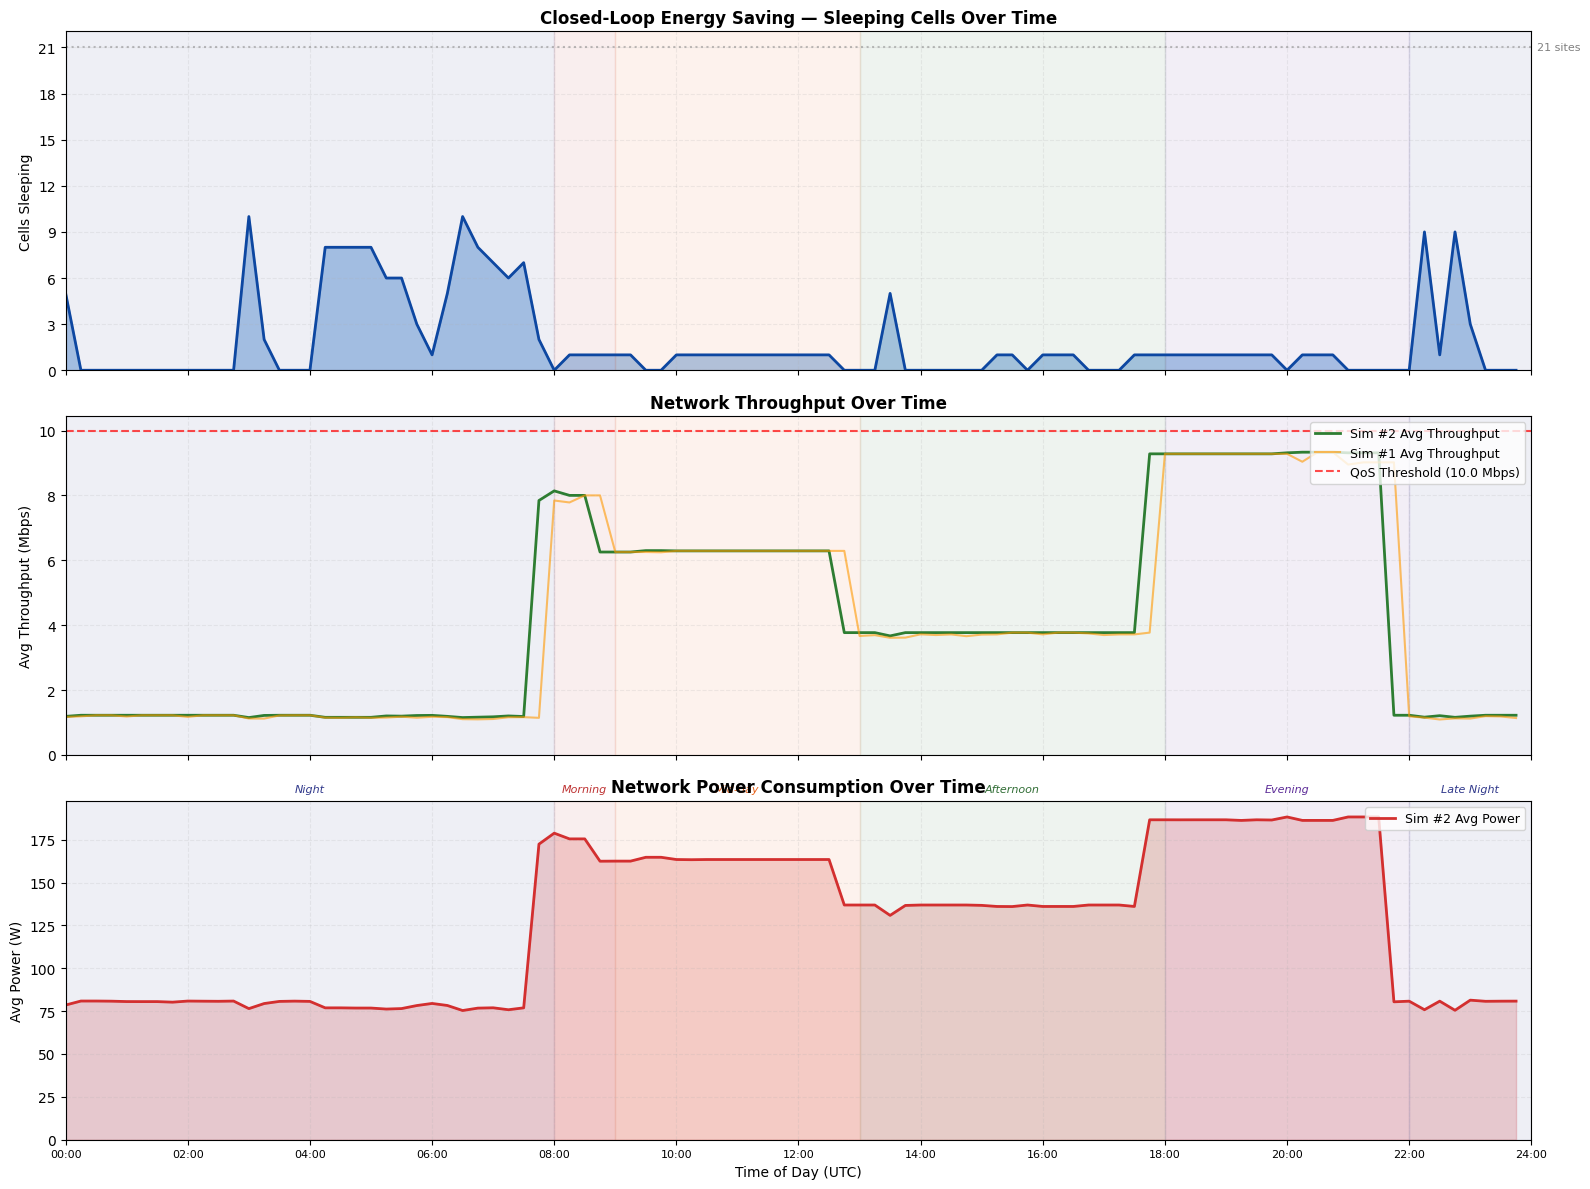


Closed-Loop Summary:
  Total recommendations generated: 409
  Total recommendations approved:  182 (44.5%)
  Peak cells sleeping: 10/21
  Average throughput (Sim #2): 4.22 Mbps
  Average power (Sim #2): 127.0 W


In [16]:
# =============================================================================
# Closed-Loop Results Visualization
# =============================================================================
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
import numpy as np

# Traffic period colors
_PERIODS = [
    {"name": "Night",      "start": 0,  "end": 8,  "color": "#1a237e"},
    {"name": "Morning",    "start": 8,  "end": 9,  "color": "#b71c1c"},
    {"name": "Mid-day",    "start": 9,  "end": 13, "color": "#e65100"},
    {"name": "Afternoon",  "start": 13, "end": 18, "color": "#1b5e20"},
    {"name": "Evening",    "start": 18, "end": 22, "color": "#4a148c"},
    {"name": "Late Night", "start": 22, "end": 24, "color": "#1a237e"},
]

# Extract time axis from summary_df
time_hours = []
for t in summary_df['time_utc']:
    dt = pd.to_datetime(t)
    time_hours.append(dt.hour + dt.minute / 60)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 12), sharex=True)

# ── Panel 1: Sleeping cells over time ──
ax1.fill_between(time_hours, summary_df['sleeping_cells'], alpha=0.35, color='#1565C0')
ax1.plot(time_hours, summary_df['sleeping_cells'], color='#0D47A1', linewidth=2)

for p in _PERIODS:
    ax1.axvspan(p['start'], p['end'], alpha=0.07, color=p['color'])

ax1.axhline(y=len(all_sites), color='gray', linestyle=':', alpha=0.5)
ax1.text(24.1, len(all_sites), f'{len(all_sites)} sites', va='center', fontsize=8, color='gray')
ax1.set_ylabel('Cells Sleeping', fontsize=10)
ax1.set_title('Closed-Loop Energy Saving — Sleeping Cells Over Time', fontsize=12, fontweight='bold')
ax1.set_ylim(bottom=0)
ax1.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
ax1.grid(axis='both', alpha=0.2, linestyle='--')

# ── Panel 2: Avg throughput over time + QoS threshold ──
ax2.plot(time_hours, summary_df['sim2_avg_thp'], color='#2E7D32', linewidth=2, label='Sim #2 Avg Throughput')
if 'sim1_avg_thp' in summary_df.columns:
    ax2.plot(time_hours, summary_df['sim1_avg_thp'], color='#FF9800', linewidth=1.5, alpha=0.6, label='Sim #1 Avg Throughput')
ax2.axhline(y=QOS_THRESHOLD, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label=f'QoS Threshold ({QOS_THRESHOLD} Mbps)')

for p in _PERIODS:
    ax2.axvspan(p['start'], p['end'], alpha=0.07, color=p['color'])

ax2.set_ylabel('Avg Throughput (Mbps)', fontsize=10)
ax2.set_title('Network Throughput Over Time', fontsize=12, fontweight='bold')
ax2.legend(fontsize=9, loc='upper right')
ax2.set_ylim(bottom=0)
ax2.grid(axis='both', alpha=0.2, linestyle='--')

# ── Panel 3: Avg power over time ──
ax3.plot(time_hours, summary_df['sim2_avg_power'], color='#D32F2F', linewidth=2, label='Sim #2 Avg Power')
ax3.fill_between(time_hours, summary_df['sim2_avg_power'], alpha=0.2, color='#D32F2F')

for p in _PERIODS:
    ax3.axvspan(p['start'], p['end'], alpha=0.07, color=p['color'])
    mid = (p['start'] + p['end']) / 2
    ax3.text(mid, 1.02, p['name'], ha='center', va='bottom', fontsize=8,
             fontstyle='italic', color=p['color'], alpha=0.9,
             transform=ax3.get_xaxis_transform())

ax3.set_ylabel('Avg Power (W)', fontsize=10)
ax3.set_xlabel('Time of Day (UTC)', fontsize=10)
ax3.set_title('Network Power Consumption Over Time', fontsize=12, fontweight='bold')
ax3.legend(fontsize=9, loc='upper right')
ax3.set_ylim(bottom=0)
ax3.grid(axis='both', alpha=0.2, linestyle='--')

# X-axis formatting
ax3.set_xlim(0, 24)
ax3.set_xticks(range(0, 25, 2))
ax3.set_xticklabels([f'{h:02d}:00' for h in range(0, 25, 2)], fontsize=8)

plt.tight_layout()

OUTPUT_DIR = str(PROJECT_ROOT / 'output')
os.makedirs(OUTPUT_DIR, exist_ok=True)
plt.savefig(f'{OUTPUT_DIR}/closed_loop_results.png', dpi=150, bbox_inches='tight')
plt.show()

# Print summary stats
total_recs = summary_df['recommendations_generated'].sum()
total_approved = summary_df['recommendations_approved'].sum()
peak_sleeping = summary_df['sleeping_cells'].max()
avg_power = summary_df['sim2_avg_power'].mean()
avg_thp = summary_df['sim2_avg_thp'].mean()

print(f"\nClosed-Loop Summary:")
print(f"  Total recommendations generated: {total_recs}")
print(f"  Total recommendations approved:  {total_approved} ({total_approved/max(total_recs,1)*100:.1f}%)")
print(f"  Peak cells sleeping: {peak_sleeping}/{len(all_sites)}")
print(f"  Average throughput (Sim #2): {avg_thp:.2f} Mbps")
print(f"  Average power (Sim #2): {avg_power:.1f} W")